In [2]:
from IPython.display import Image

### MNIST 손글씨 숫자 분류 (by MLP)

MNIST MLP Classification

> ### collect > examine > train > evaluate > save > predict

-----
#### google drive (0512 File download)
 
 - create New Notebook
     - interpreter : spark3


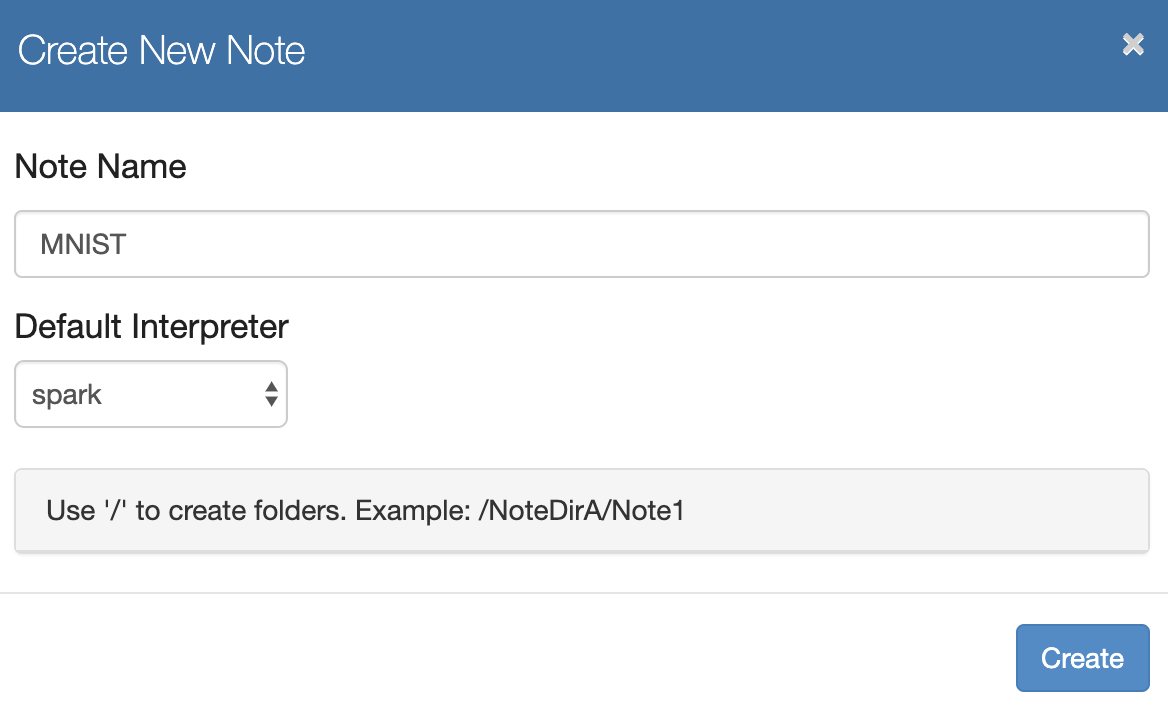

In [3]:
Image('./capture/mnist_01.png')

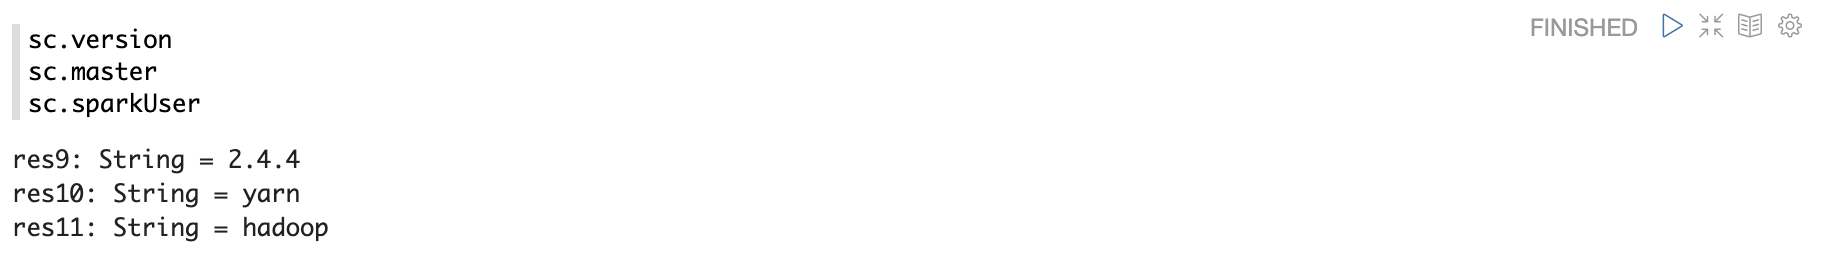

In [4]:
Image('./capture/mnist_02.png')

-----
### File Upload

 - hadoop-master-01:50170
     - create directory : MNIST
     - /kikang/data/MNIST : mnist 파일 3개 업로드

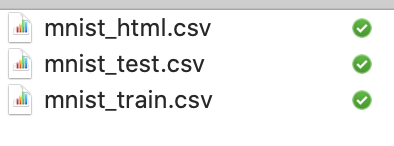

In [5]:
Image('./capture/mnist_03.png')

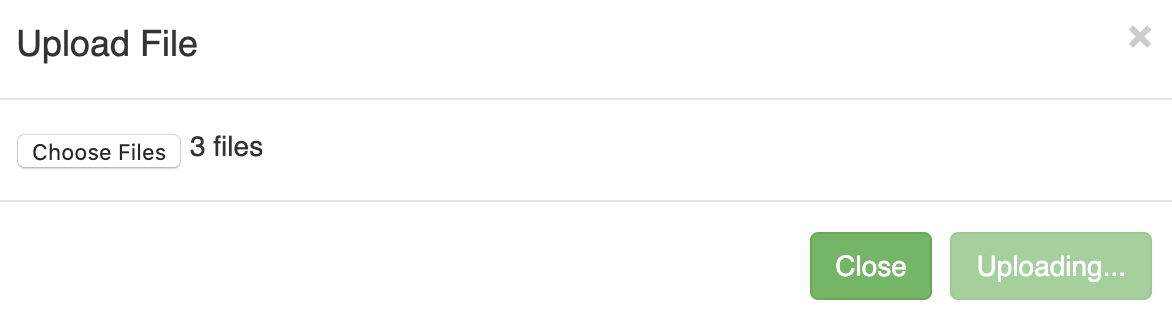

In [6]:
Image('./capture/mnist_04.png')

----
### Data Loading

In [ ]:
val train_raw = spark.read.csv("hdfs://hadoop-master-01:9000/kikang/data/MNIST/mnist_train.csv")
val test_raw = spark.read.csv("hdfs://hadoop-master-01:9000/kikang/data/MNIST/mnist_test.csv")

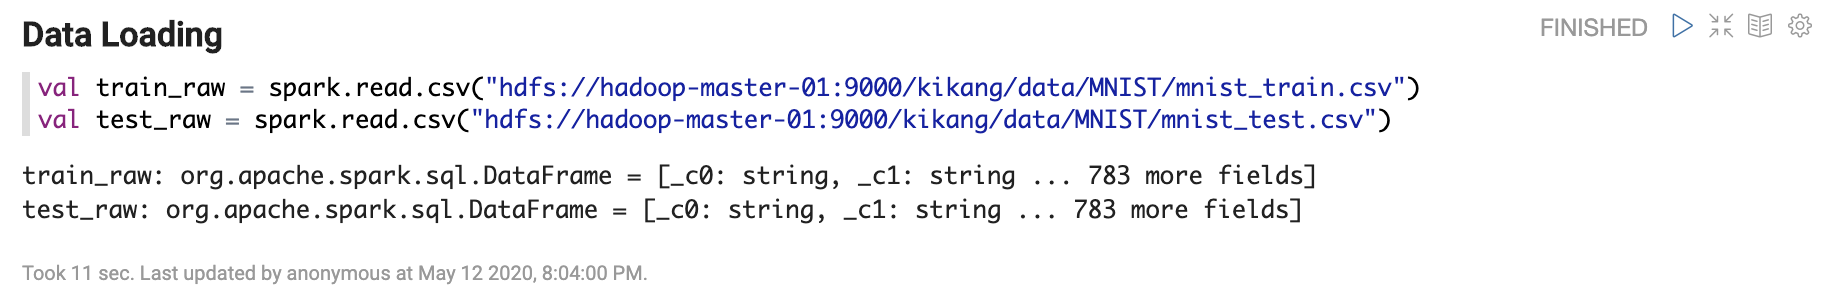

In [8]:
Image('./capture/mnist_05.png')

In [ ]:
val toIntUDF = spark.udf.register("to_int", (arg1: String) => arg1.toInt)

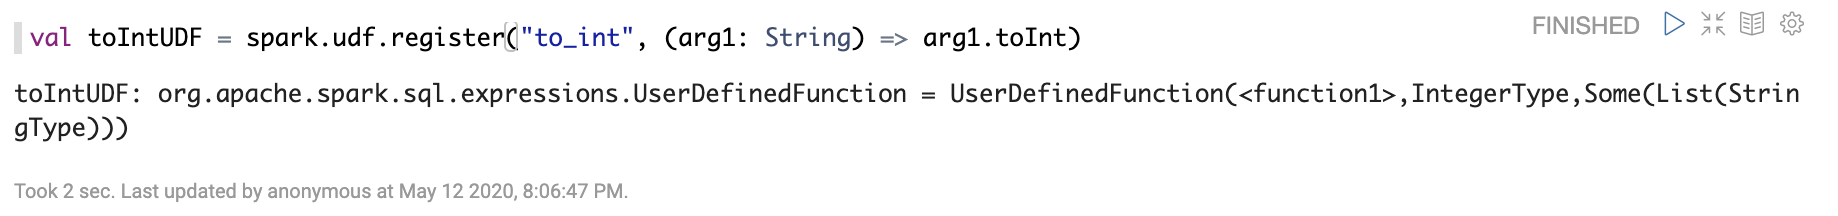

In [9]:
Image('./capture/mnist_06.png')

-------
### spark warehouse database list + table list

In [ ]:
spark.catalog.listDatabases.show(false)
spark.catalog.listTables.show(false)
spark.catalog.listFunctions.show(false)
spark.catalog.listFunctions.filter('name like "%to_%").show(false)

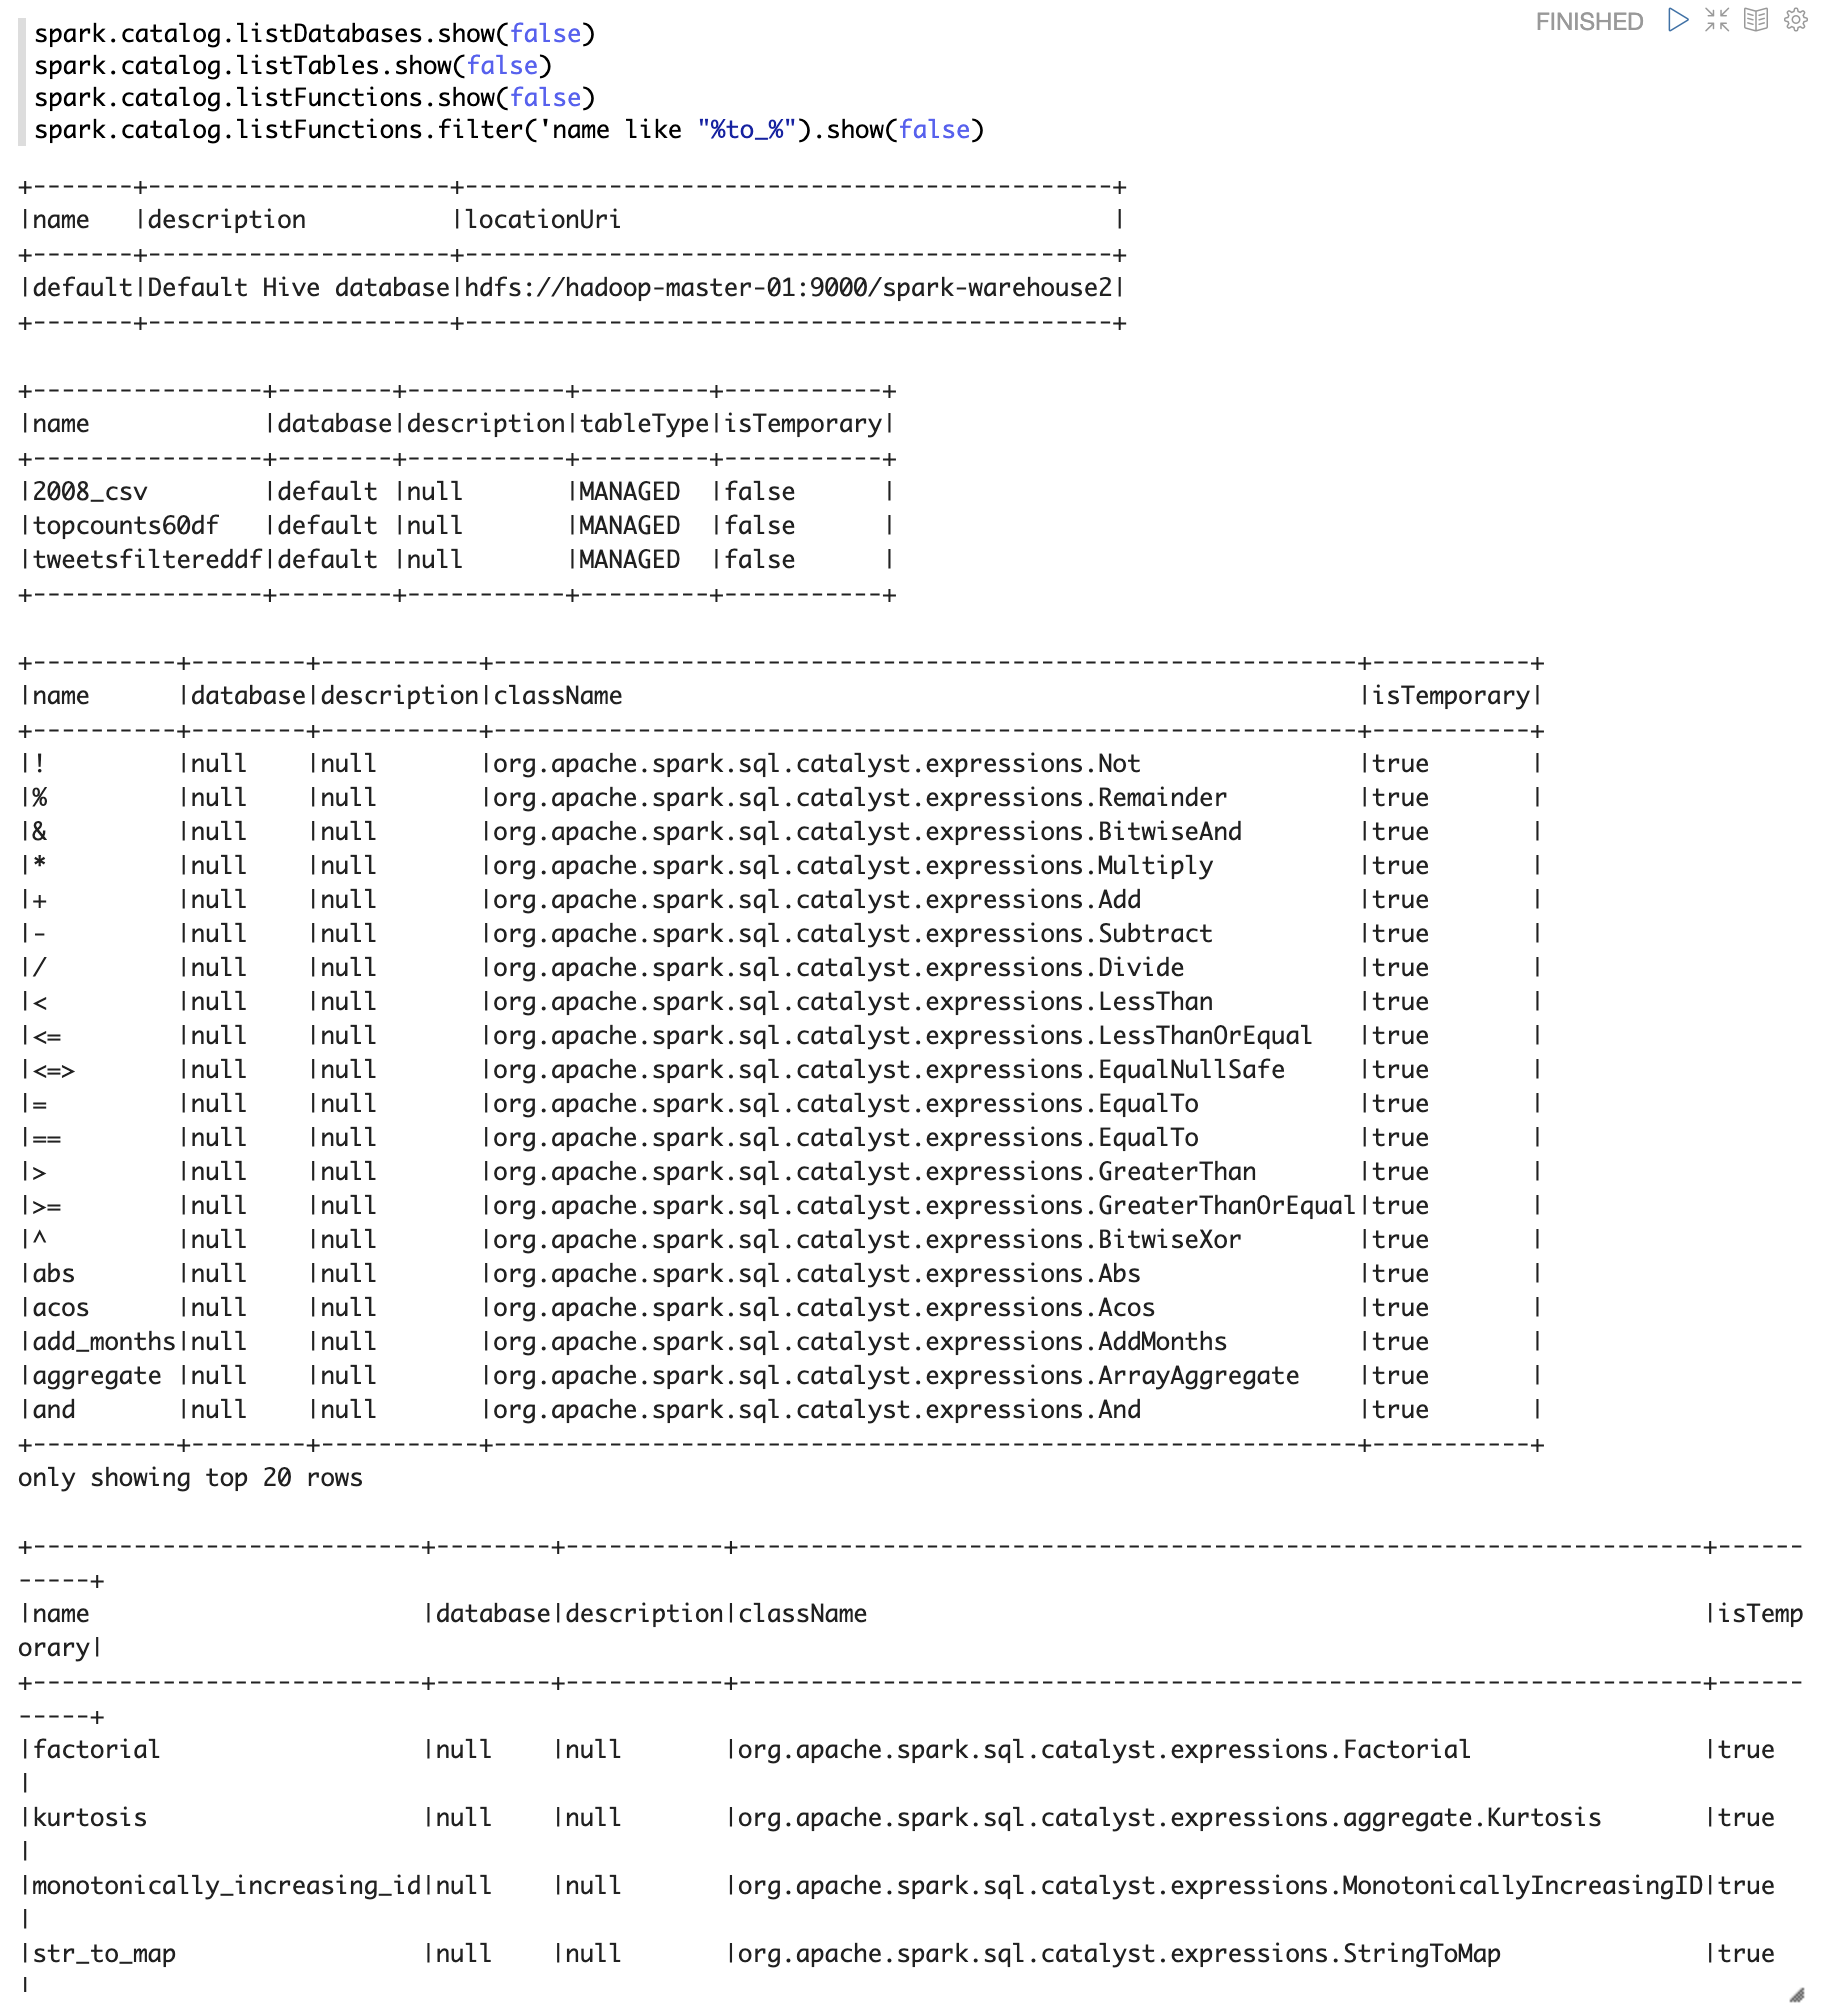

In [10]:
Image('./capture/mnist_07.png')

In [ ]:
train_raw.createOrReplaceTempView("train_raw")
test_raw.createOrReplaceTempView("test_raw")

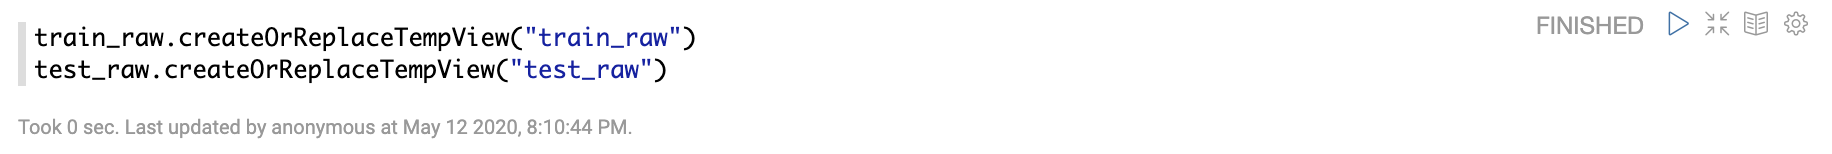

In [11]:
Image('./capture/mnist_08.png')

-----
#### 재실행

In [ ]:
spark.catalog.listDatabases.show(false)
spark.catalog.listTables.show(false)
spark.catalog.listFunctions.show(false)
spark.catalog.listFunctions.filter('name like "%to_%").show(false)

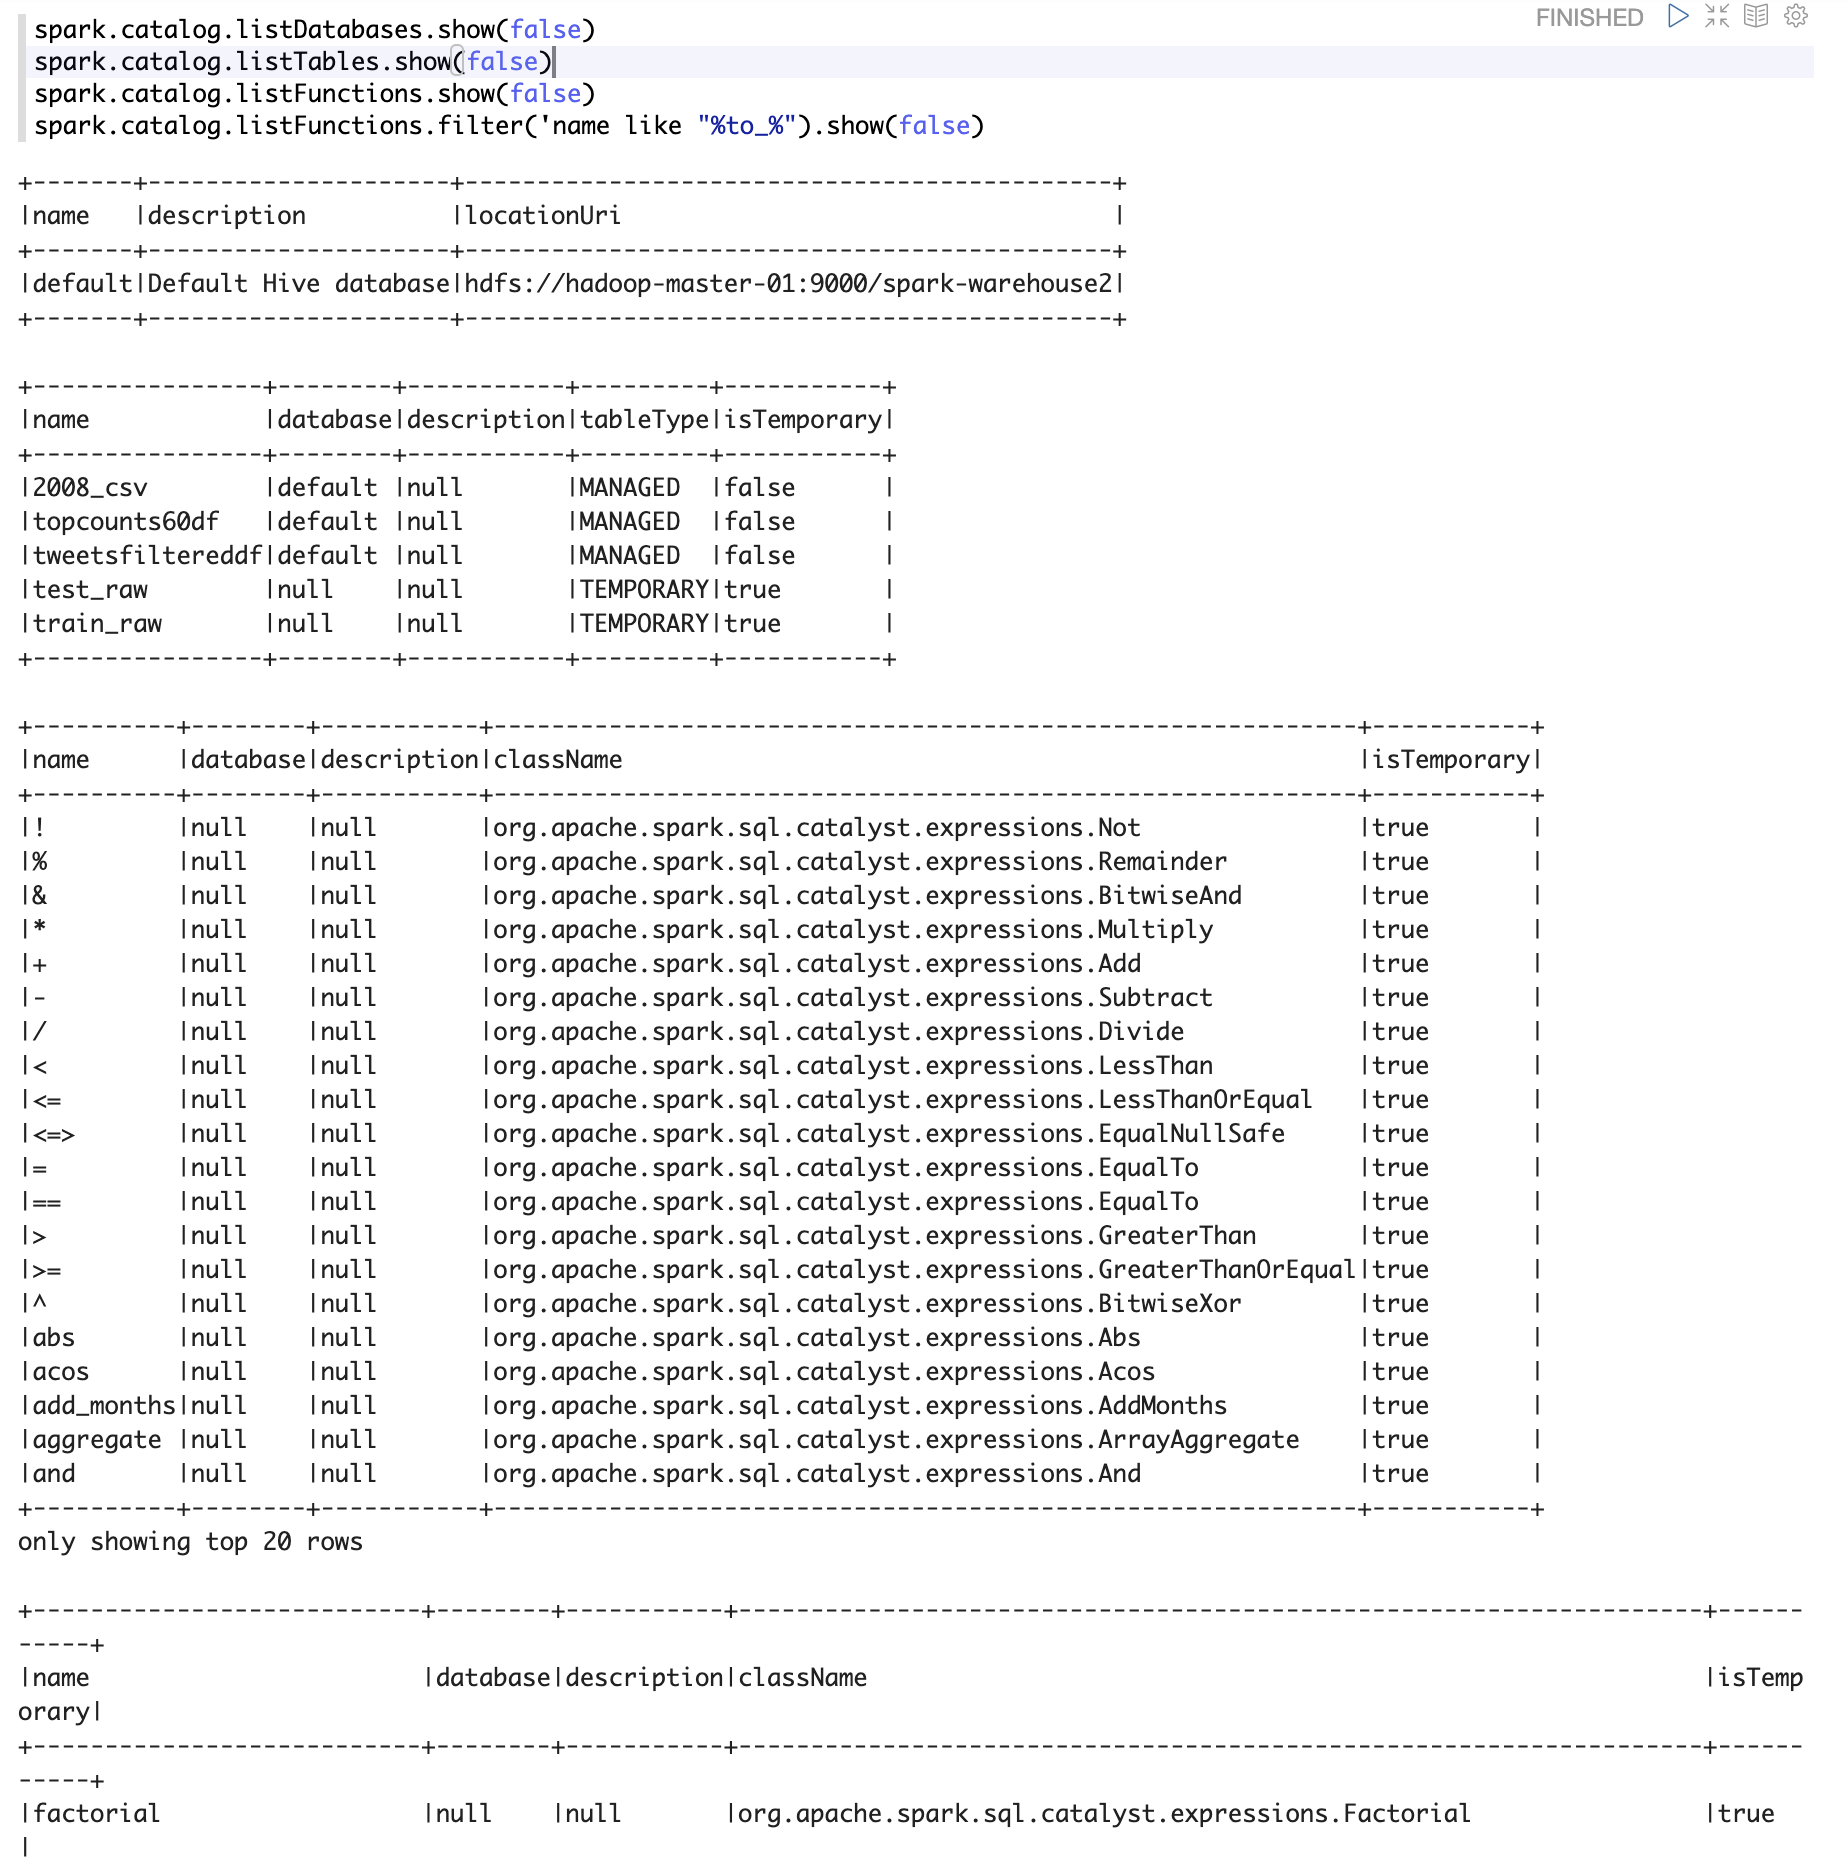

In [12]:
Image('./capture/mnist_09.png')

----
### Create SQL query

#### sql문에서 사용할 컬럼 목록(1개 label + 784개 pixel) 스트링 생성 w/ 테이터 타입 변경 + 컬럼명 변경

In [ ]:
val cols = 0 to 784
val colsStr = cols.map(i => {
    if(i == 0)
        s"""to_int(_c$i) as label"""
    else
        s"""to_int(_c$i) as pixel${i-1}"""
}).mkString(", ")

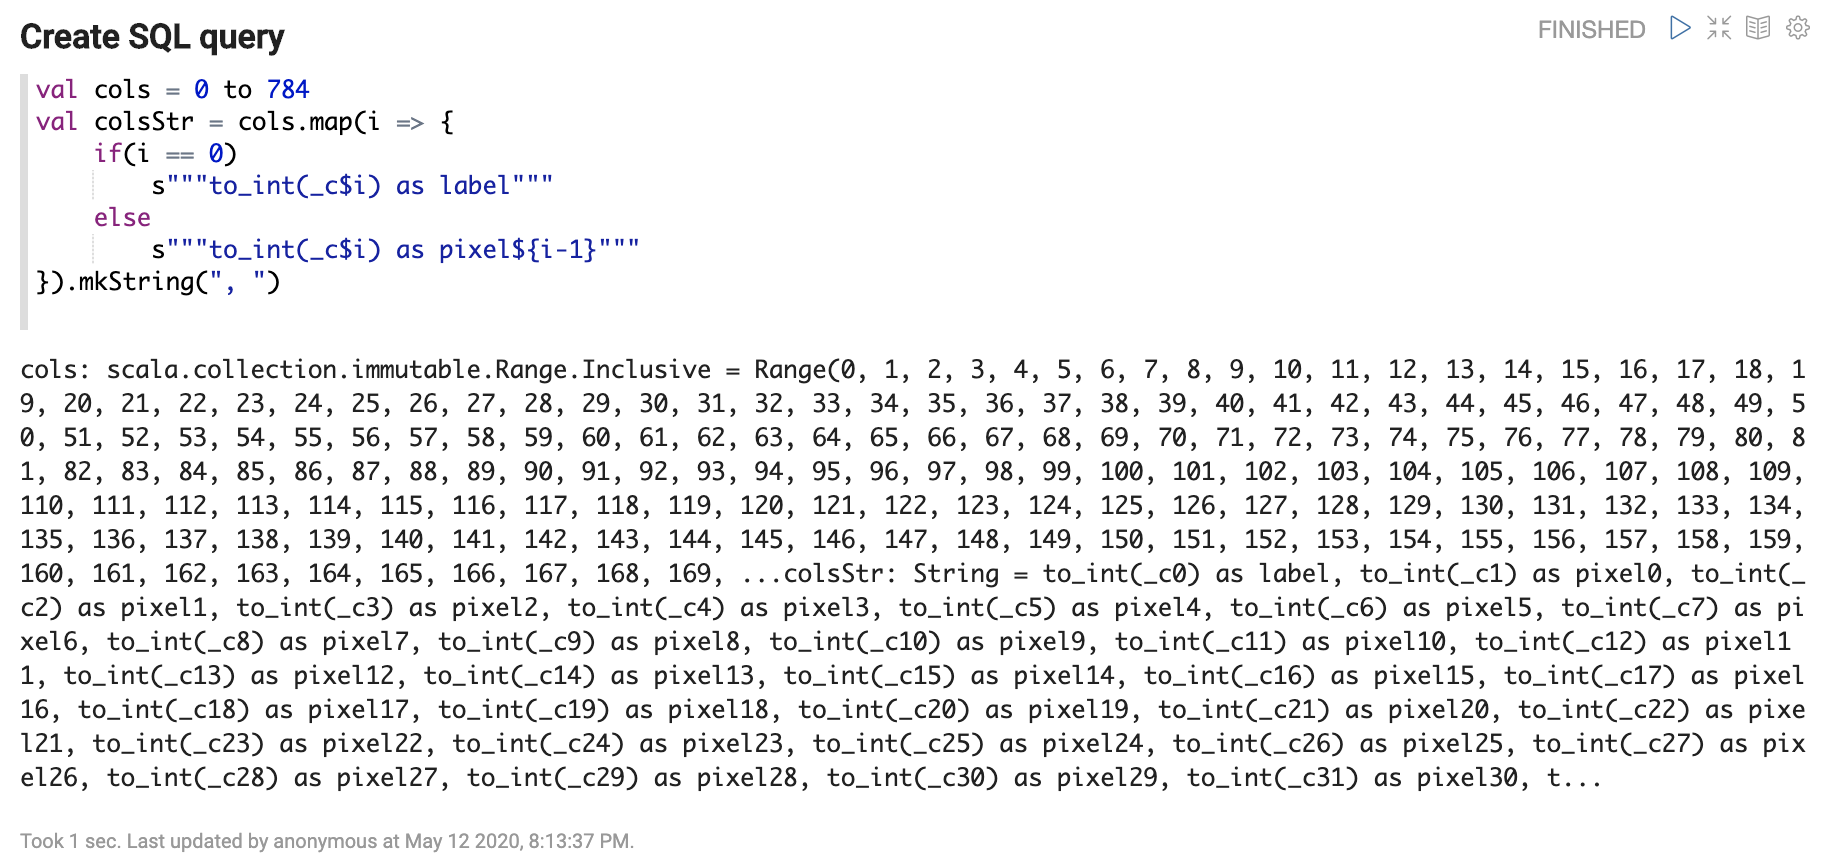

In [13]:
Image('./capture/mnist_10.png')

#### sql문에서 사용할 컬럼 목록(1개 label + 784개 pixel) 스트링...

In [ ]:
colsStr

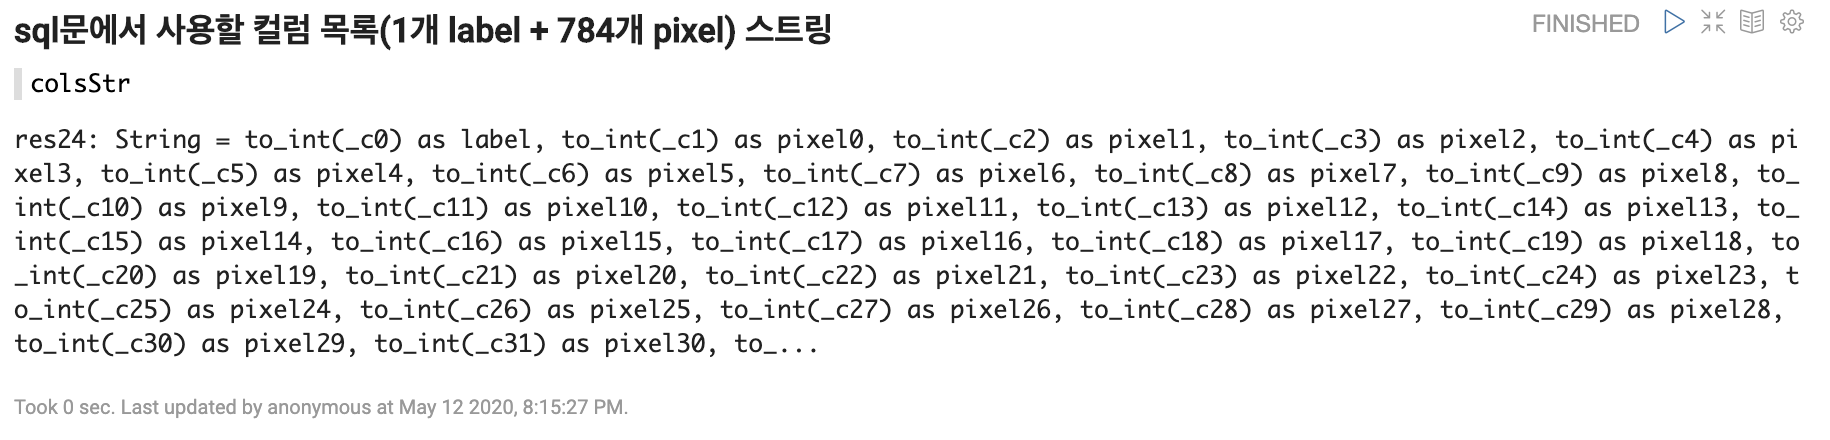

In [14]:
Image('./capture/mnist_11.png')

In [ ]:
val train_sql = s""" 
select 
    $colsStr 
from 
    train_raw
"""
        
val test_sql = s""" 
select 
    $colsStr 
from 
    test_raw
"""

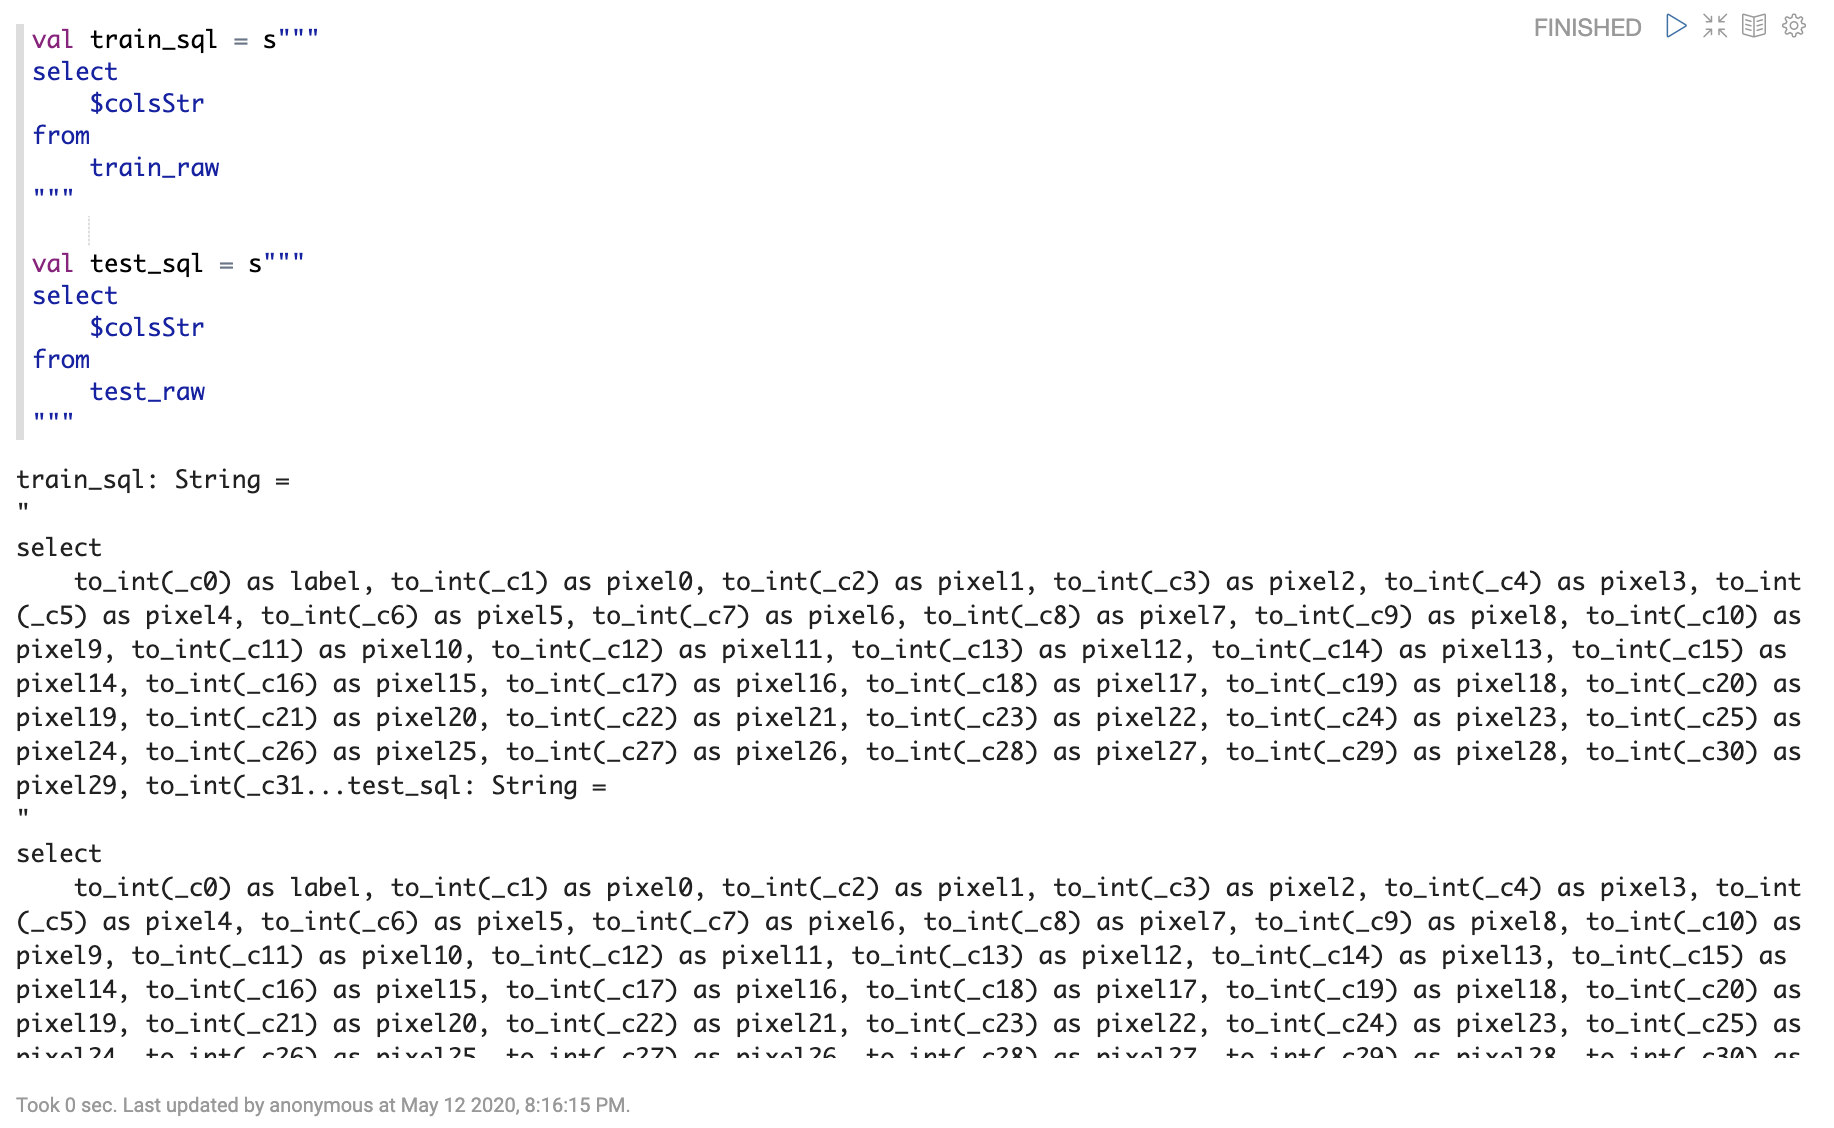

In [15]:
Image('./capture/mnist_12.png')

In [ ]:
val train = spark.sql(train_sql)
val test = spark.sql(test_sql)

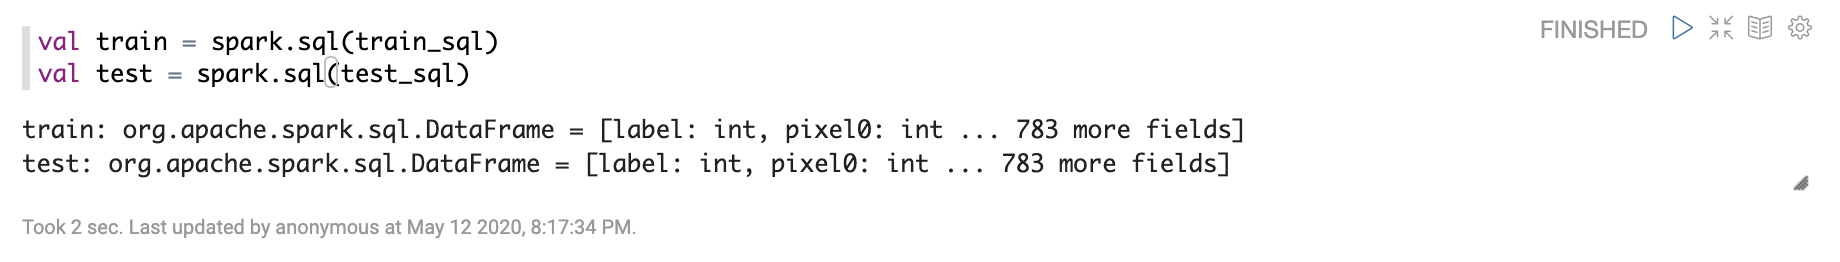

In [16]:
Image('./capture/mnist_13.png')

### Info Schema

In [ ]:
train_raw.printSchema

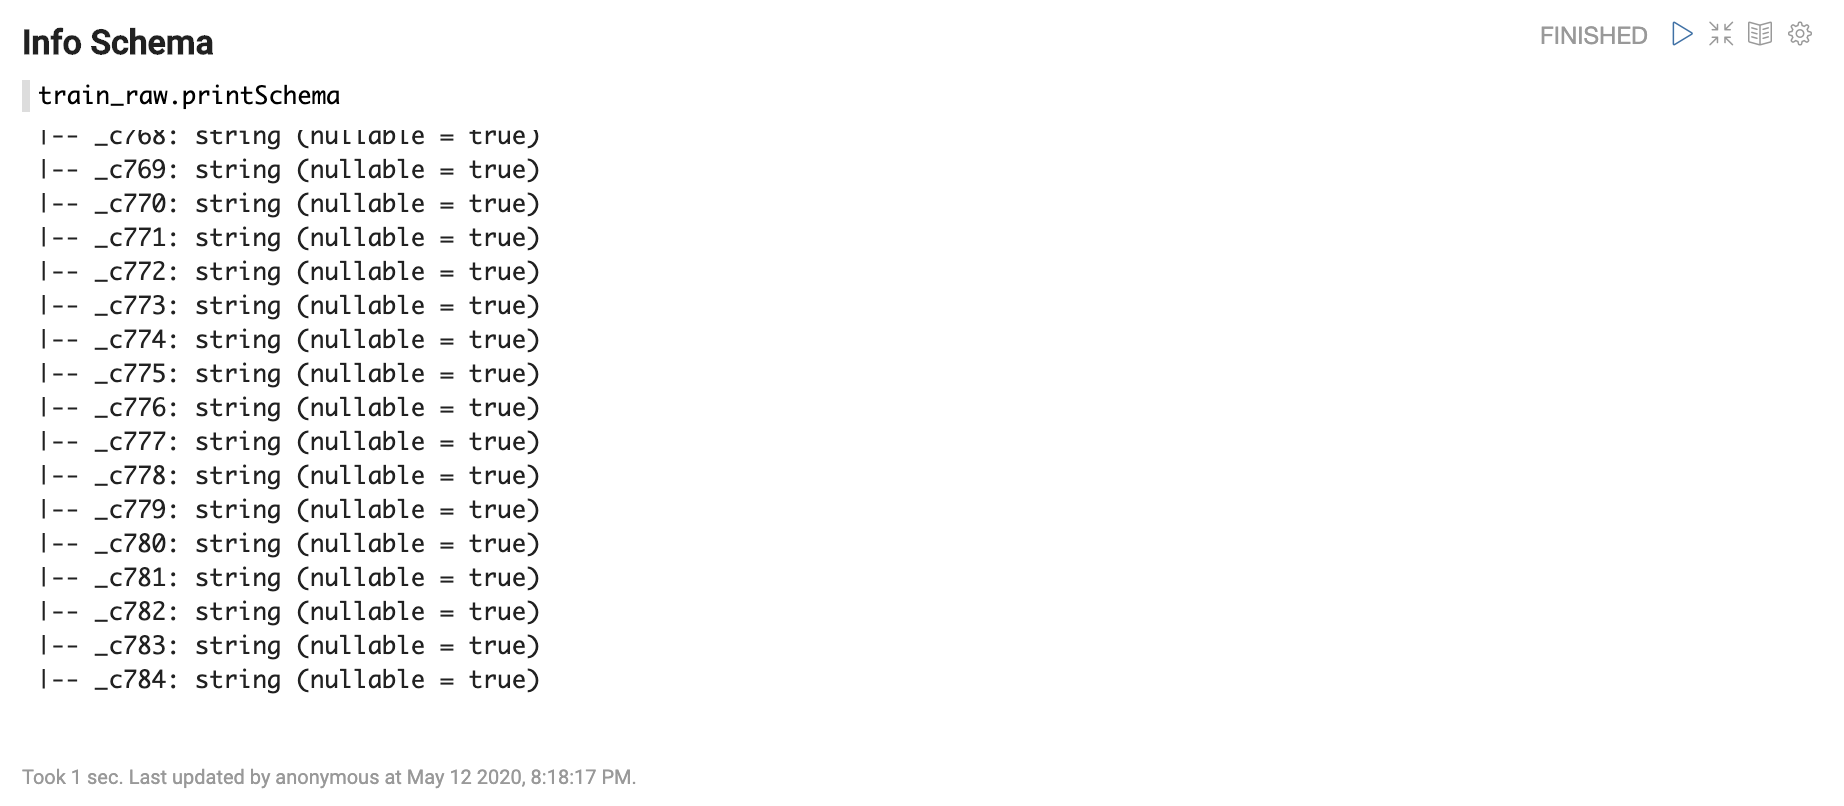

In [17]:
Image('./capture/mnist_14.png')

-----
### train / test 형변환 (int)

In [ ]:
val train = spark.sql(train_sql)
val test = spark.sql(train_sql)

train.printSchema

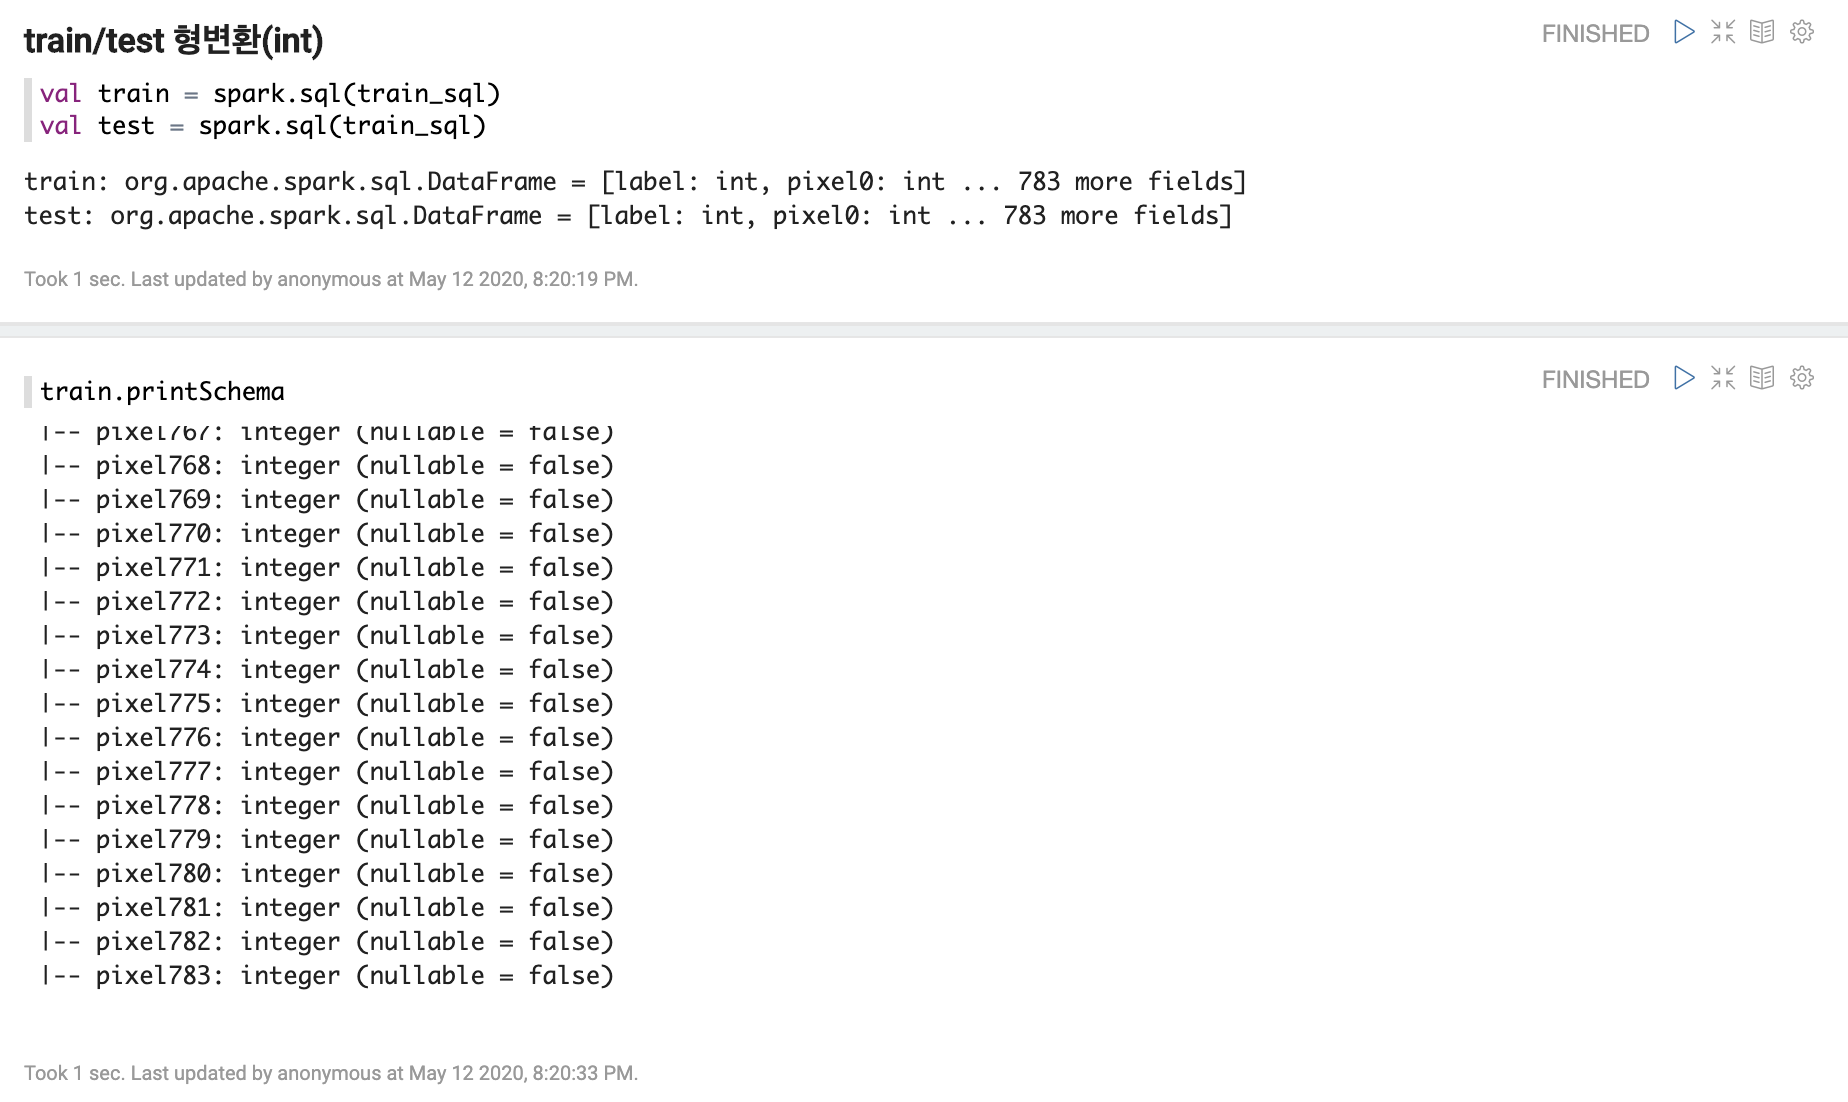

In [18]:
Image('./capture/mnist_15.png')

---
### train / test data cache

In [ ]:
train.persist(org.apache.spark.storage.StorageLevel.MEMORY_ONLY)  
test.persist(org.apache.spark.storage.StorageLevel.MEMORY_ONLY)

train.count()  
test.count()

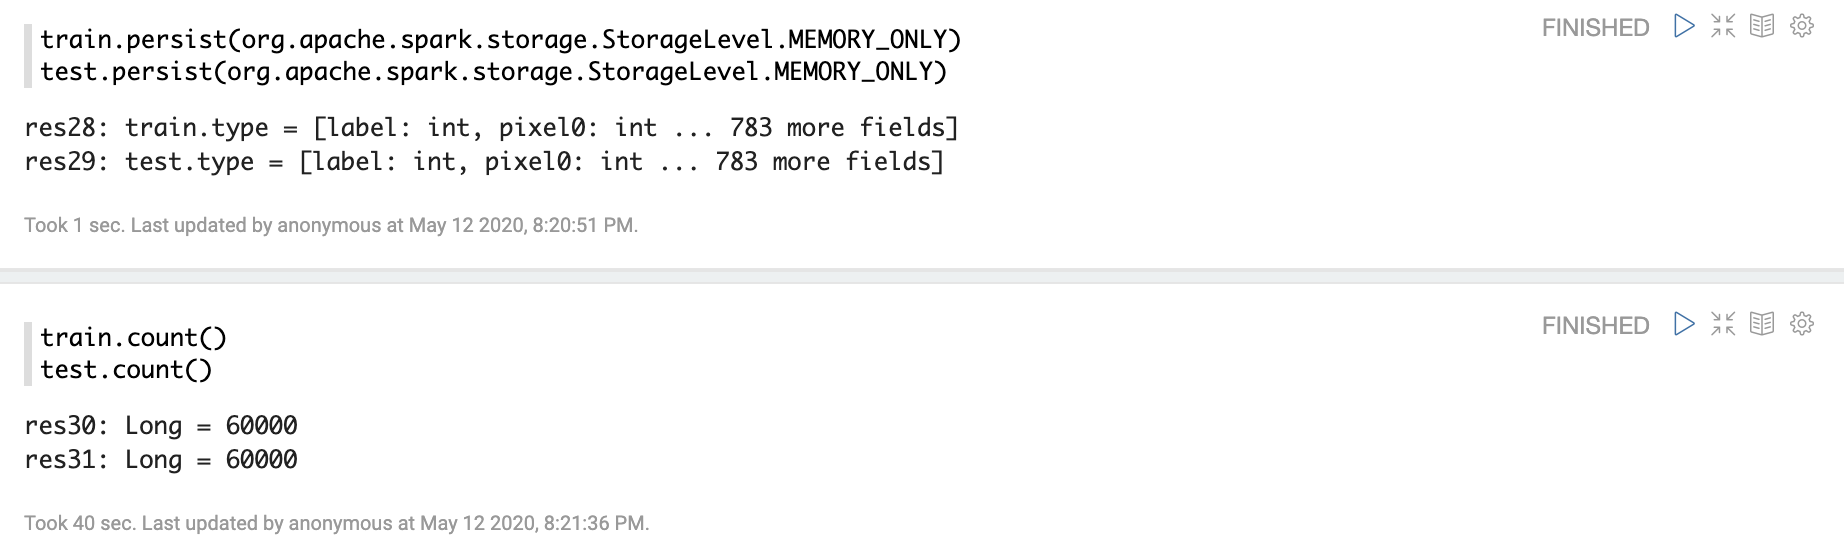

In [19]:
Image('./capture/mnist_16.png')

In [ ]:
val label = "label"  
val labels = Seq("0","1","2","3","4","5","6","7","8","9")
val layers = Array[Int](features.length, 784, 800, labels.length)
var features: Array[String] = (0 to 783).map(i => s"pixel${i}").toArray
features.size

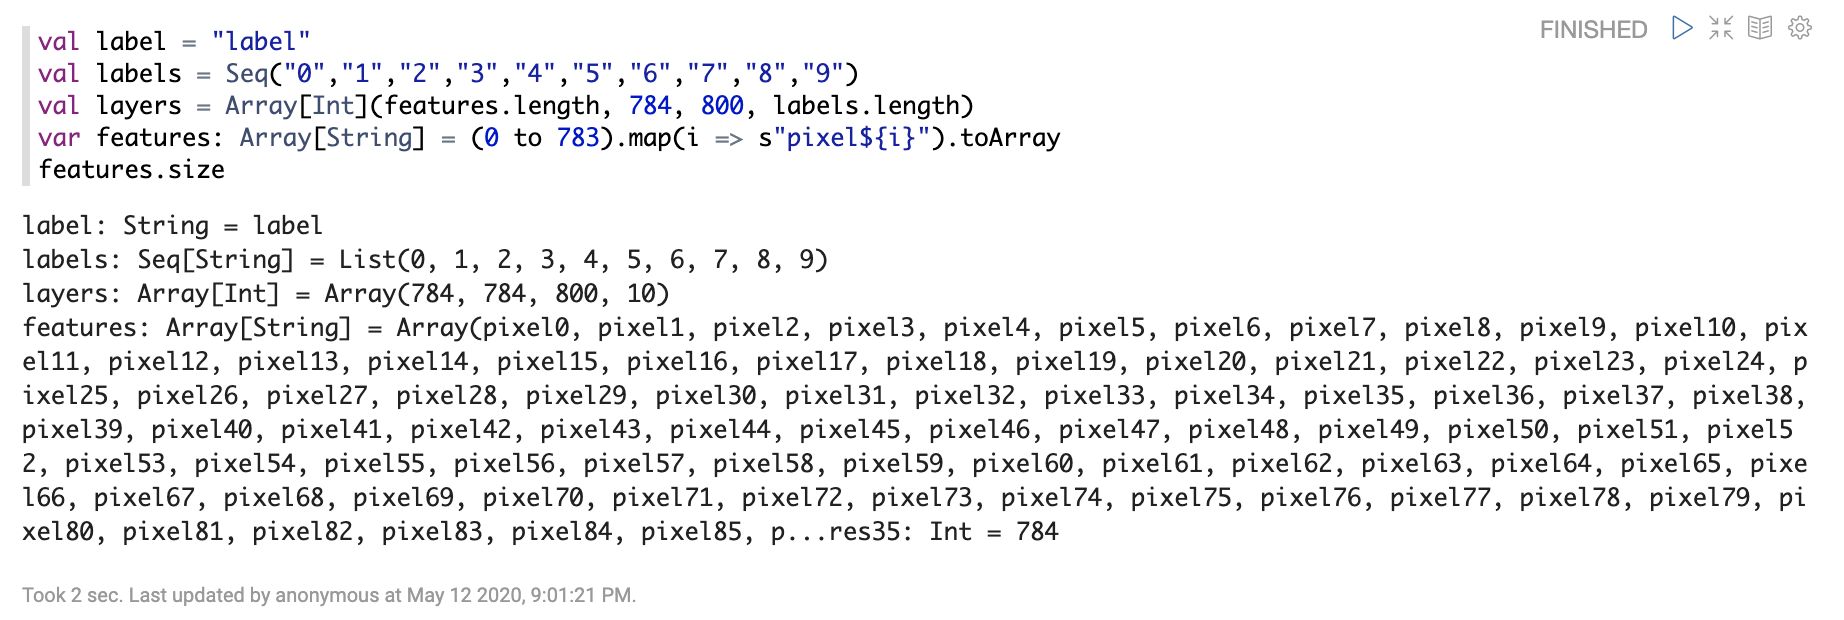

In [22]:
Image('./capture/mnist_19.png')

----
### 테스트, Array 관련 연산 ':+' '++'

In [ ]:
var arr: Array[String] = Array()
var arr2: Array[String] = Array("col3", "col4")
arr = arr :+ "col1"
arr = "col0" +: arr
var arr3 = arr ++ arr2
var arr4 = arr2 ++ arr

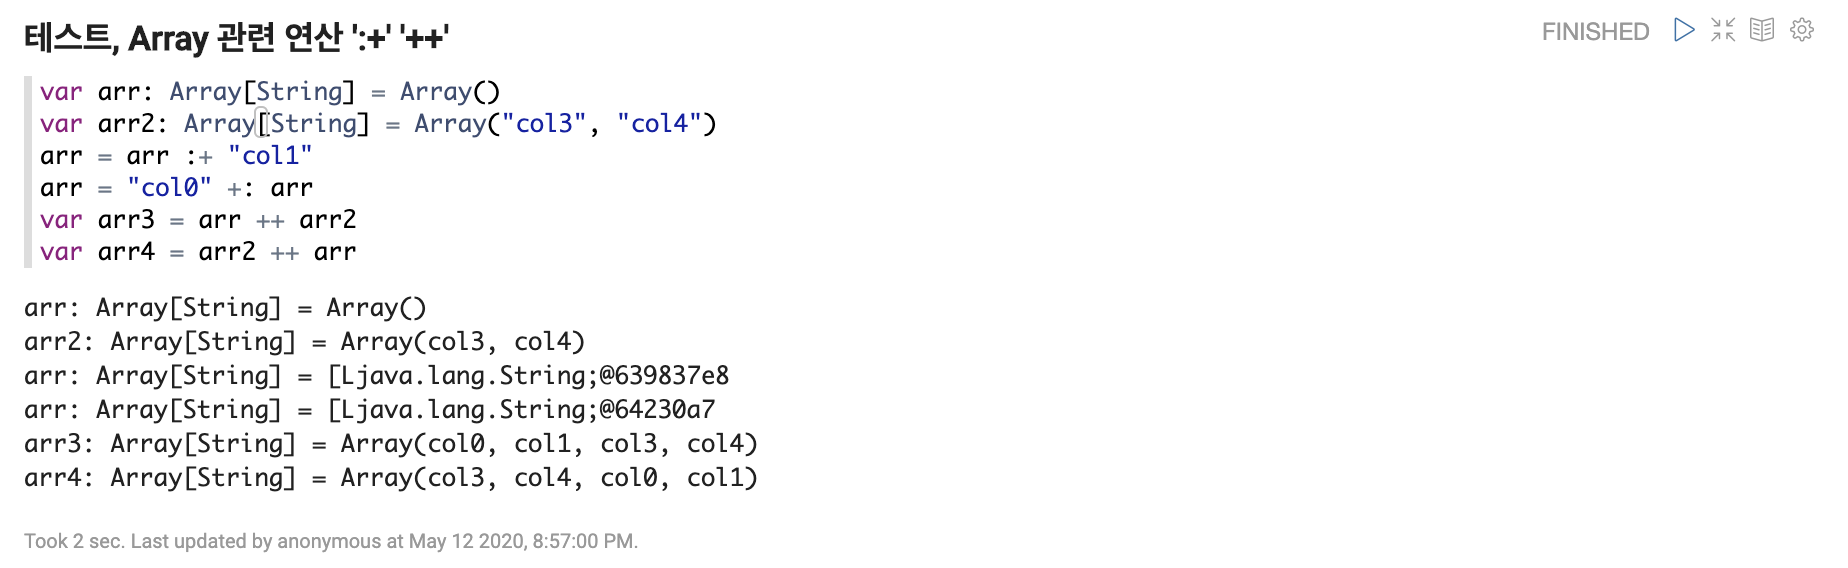

In [20]:
Image('./capture/mnist_17.png')

### 테스트, feature 컬럼명 784개 배열 구성

In [ ]:
var features: Array[String] = Array()
(0 to 783).foreach(i => {
    features = features :+ s"""pixel$i"""
})

features.size
features

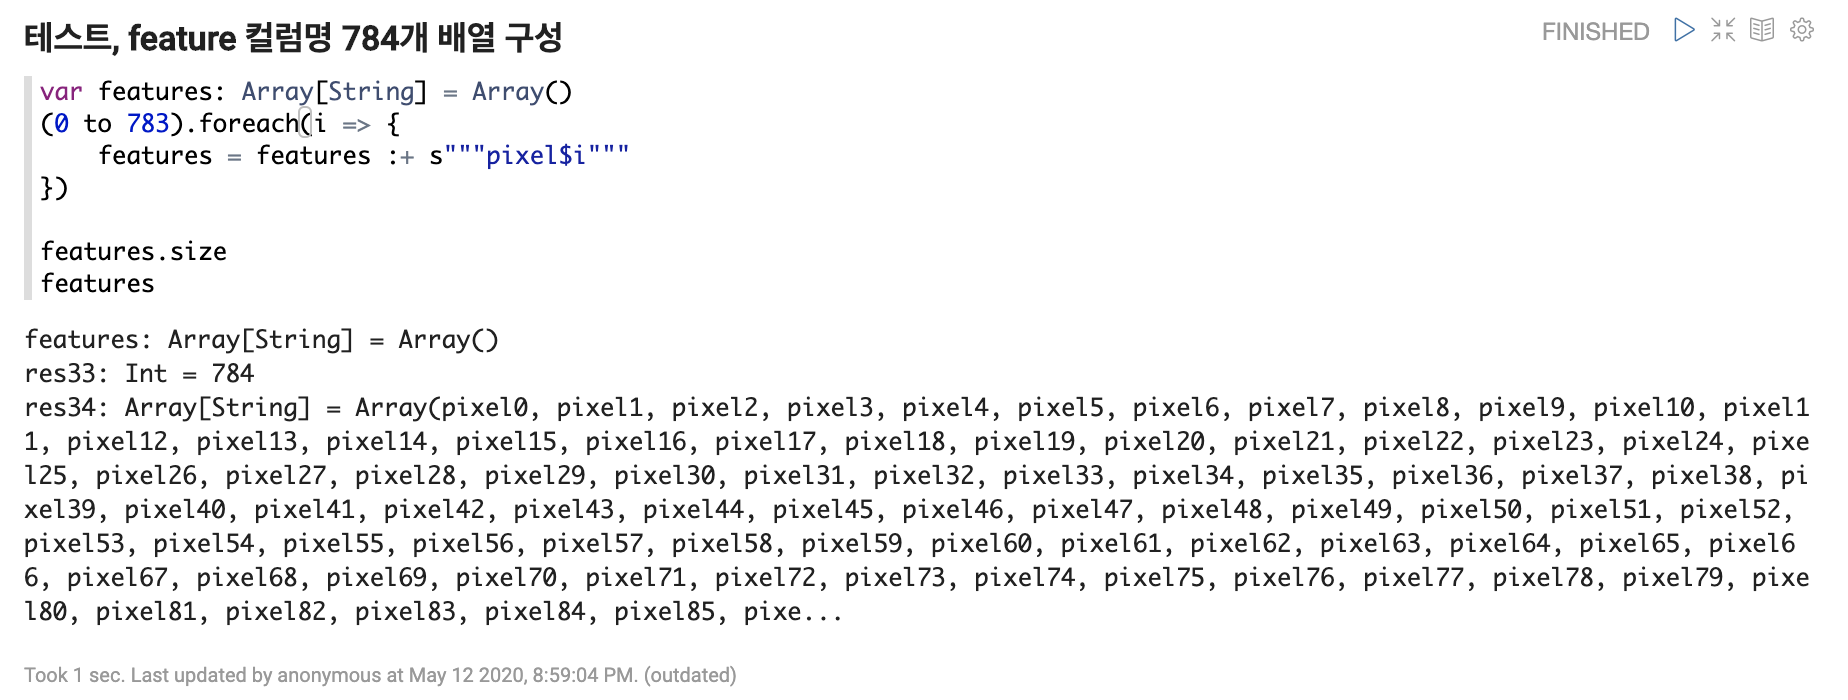

In [21]:
Image('./capture/mnist_18.png')

-----
### Train

#### "VectorAssembler" > > "StringIndexer" > > "MultilayerPerceptronClassifier" > > "IndexToString"

-----

> - VectorAssembler : 여러개의 숫자 column을 vector 형태의 한 column으로 변환
> - StringIndexer : category string 값을 index 값으로 변환
> - MultilayerPerceptronClassifier 
    - 하나의 입력층 , 여러개의 은닉층
    - 가능한 레이블 개수와 같은 수의 신경 수를 가진 출력층
    - 입력층과 은닉층에 있는 모든 신경은 sigmoid 활성함수 사용
    - 출력층에서의 활성함수는 softmax 함수 사용
> - IndexToString : 가장 큰 값의 Index 출력

-----
### import 

In [ ]:
import org.apache.spark.ml.{Pipeline,PipelineModel}  
import org.apache.spark.ml.feature.{VectorAssembler,StringIndexer,IndexToString}  
import org.apache.spark.ml.classification.{MultilayerPerceptronClassifier}  

- sum columns 

In [ ]:
val assembler = { new VectorAssembler()  
  .setInputCols(features)
}

- training :: fit

In [ ]:
val stringIndexer = { new StringIndexer()  
  .setInputCol(label)
  .fit(train)
}

- setLabelCol : StringIndexer 를 통해서 나온 category data 의 column 명 지정
 - strginIndexer 를 타고나오면 결과가 바뀜.

- setFeaturesCol : feature 값
- setMaxIter(10000) : 반복이 의미없다고 생각하면 stop training

In [ ]:
val mlp = { new MultilayerPerceptronClassifier()  
  .setLabelCol(stringIndexer.getOutputCol)
  .setFeaturesCol(assembler.getOutputCol)
  .setLayers(layers)
  .setSeed(42L)      
  .setBlockSize(128)
#.setMaxIter(10000) 
#.setMaxIter(10)   
  .setMaxIter(2)   
  .setTol(1e-7)
}

In [ ]:
val indexToString = { new IndexToString()  
  .setInputCol(mlp.getPredictionCol)
  .setLabels(stringIndexer.labels)
}

val pipeline = { new Pipeline()  
  .setStages(Array(assembler, stringIndexer, mlp, indexToString))
}

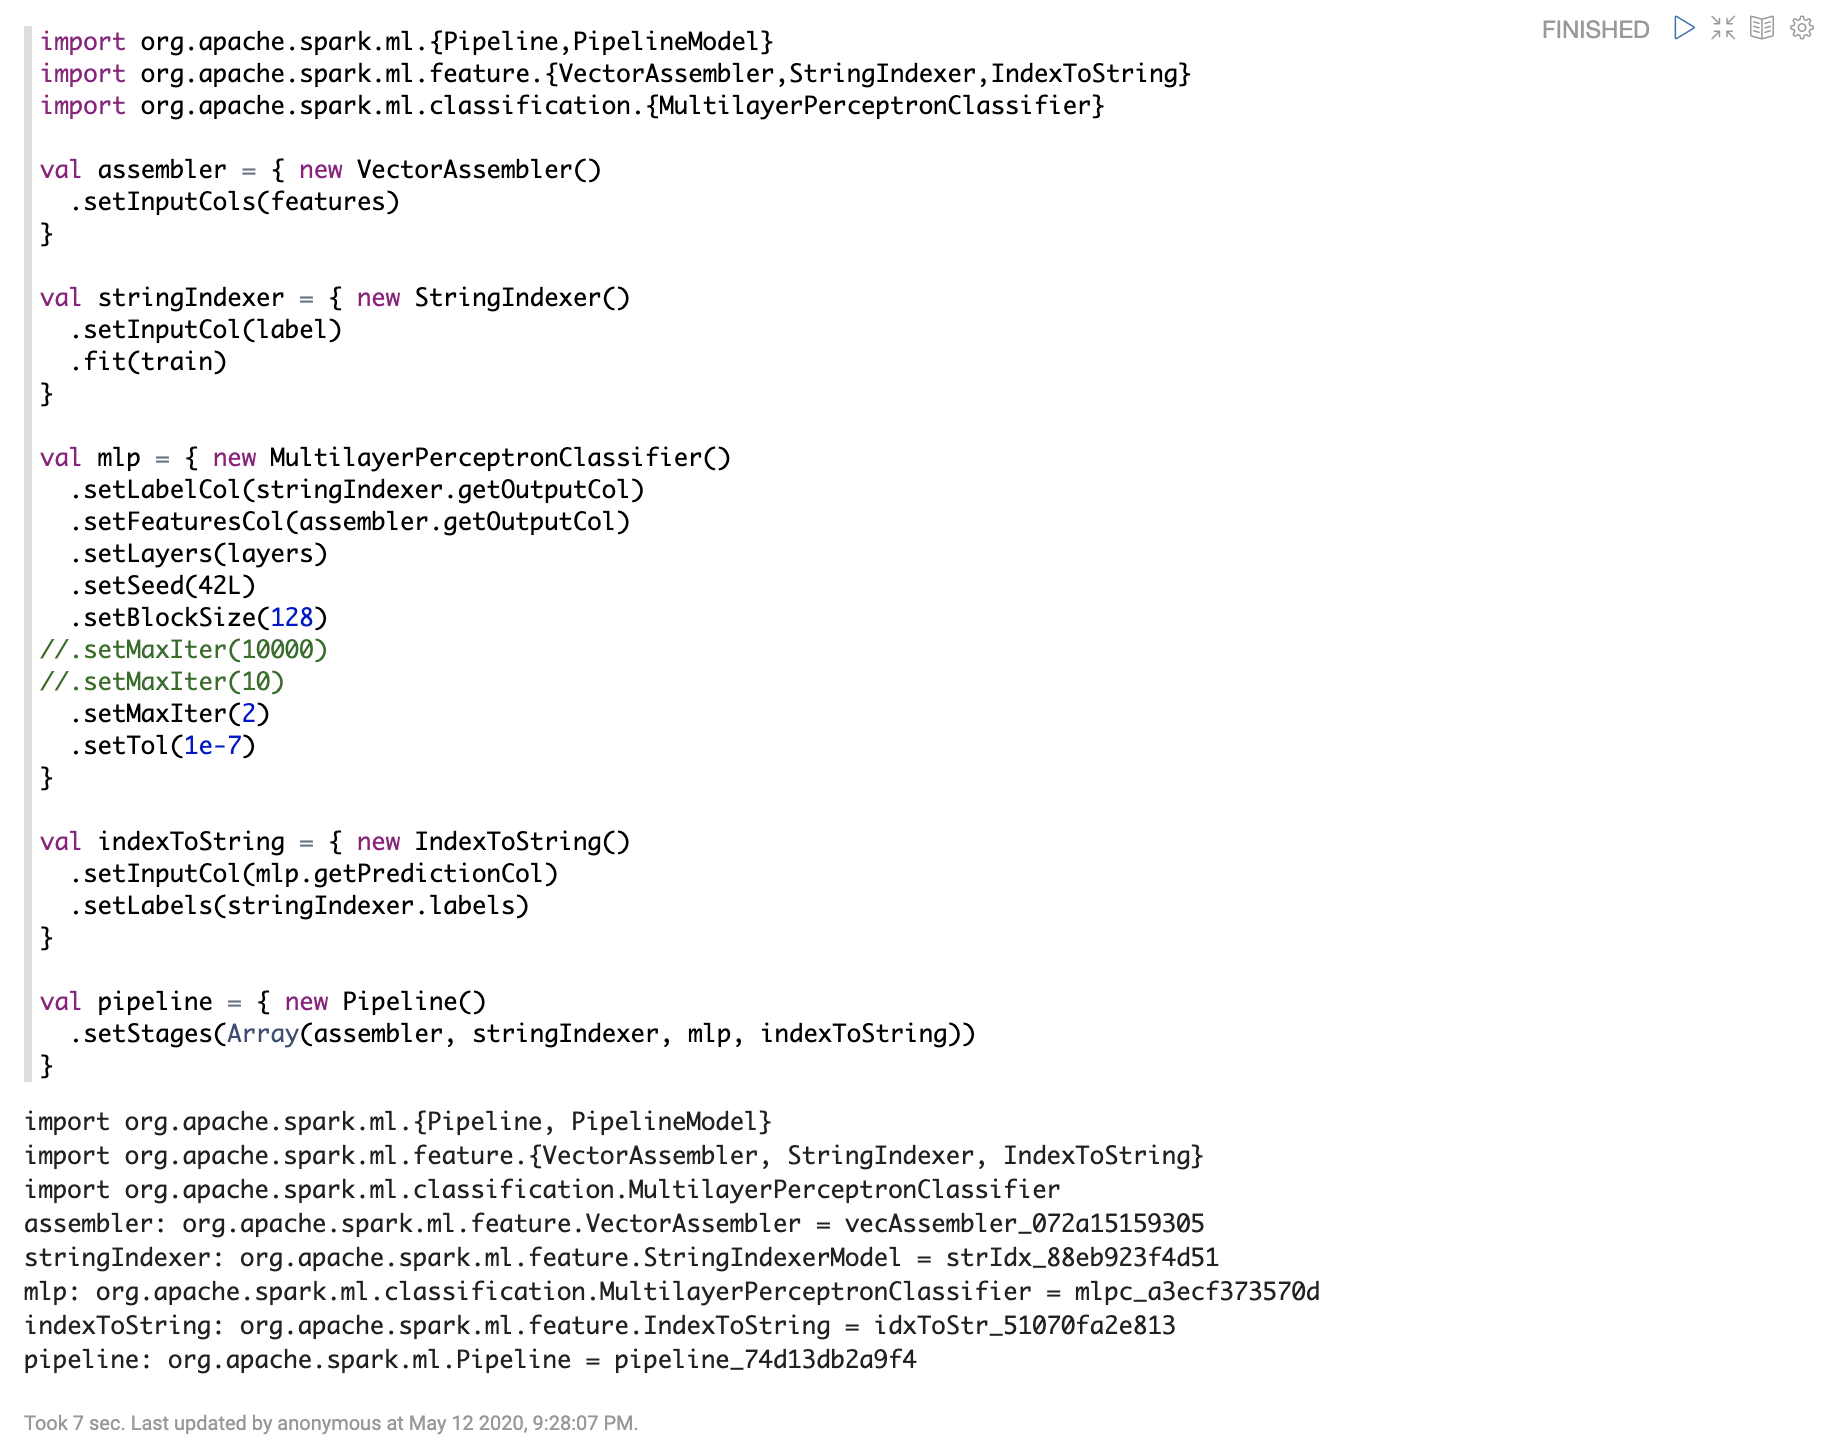

In [25]:
Image('./capture/mnist_20.png')

In [ ]:
val model = pipeline.fit(train)

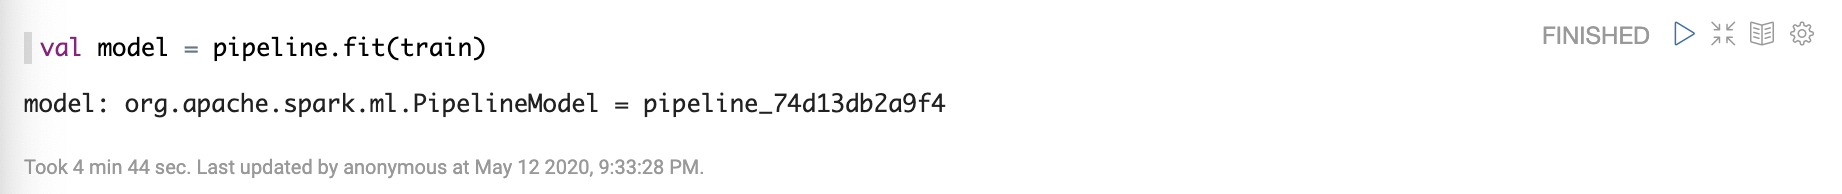

In [26]:
Image('./capture/mnist_21.png')

In [ ]:
var result = model.transform(test)

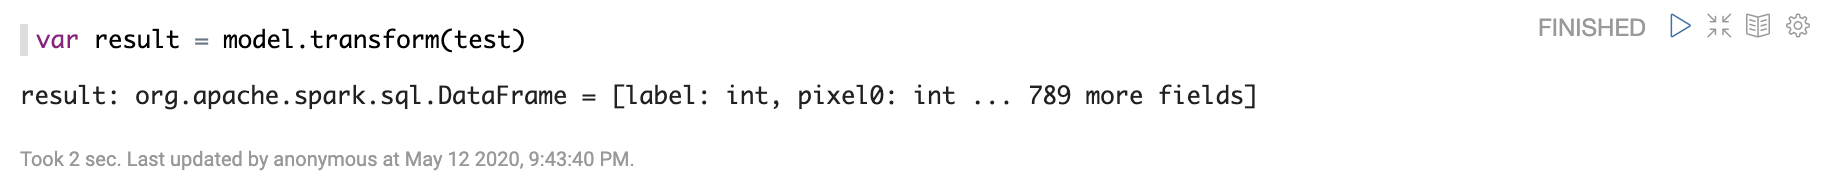

In [27]:
Image('./capture/mnist_22.png')

In [ ]:
test.printSchema

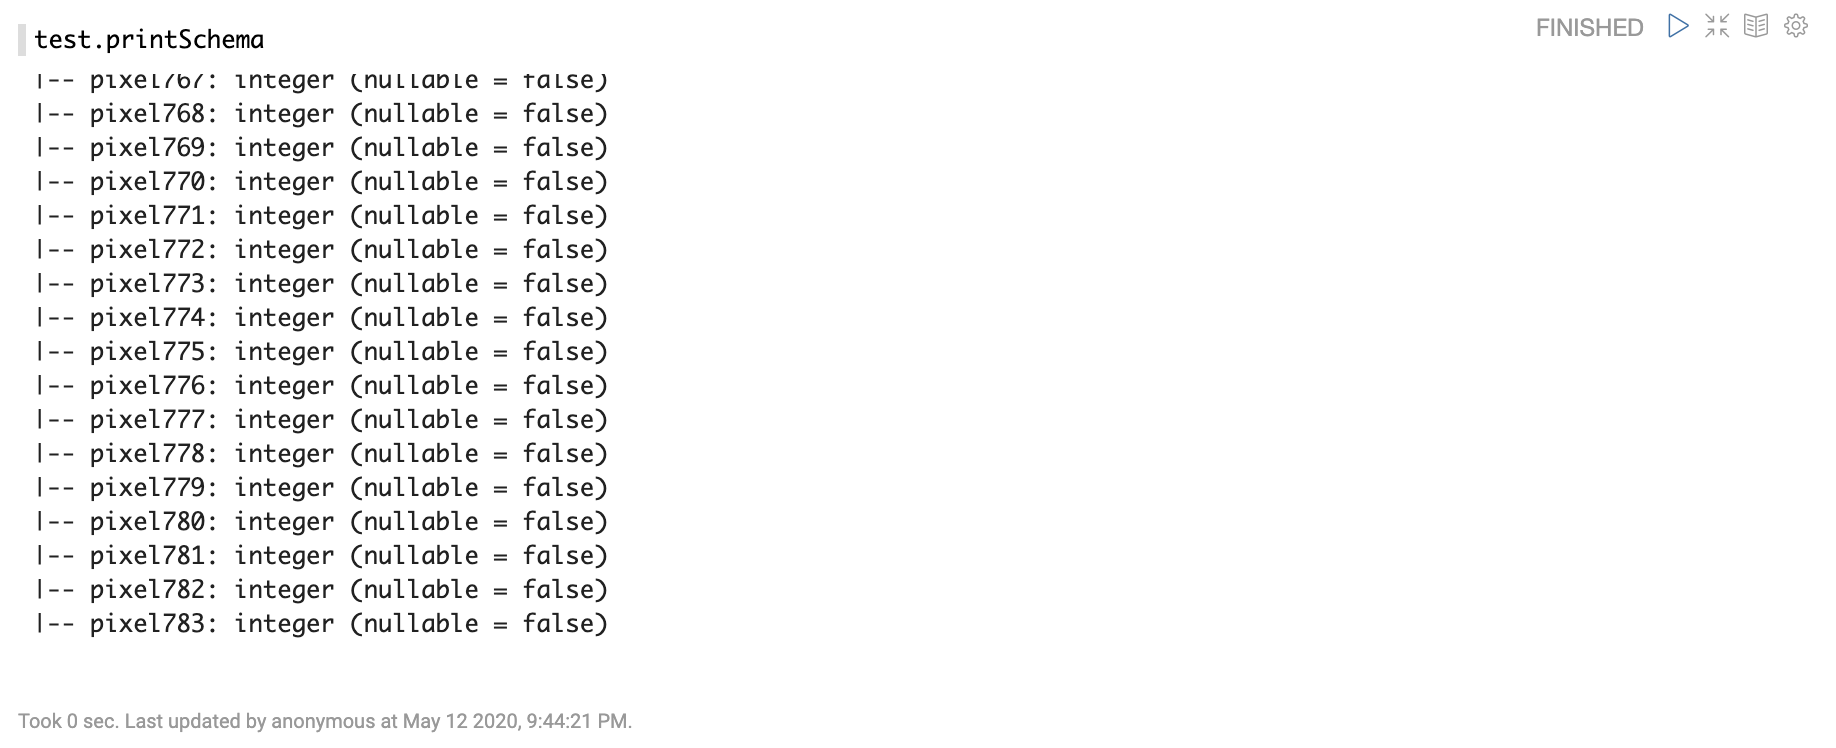

In [28]:
Image('./capture/mnist_23.png')

-----
- 원본 그대로 유지

 - softmax 적용 전 : rowPrediction
 - softmax 적용 후 : probability

In [ ]:
result.printSchema

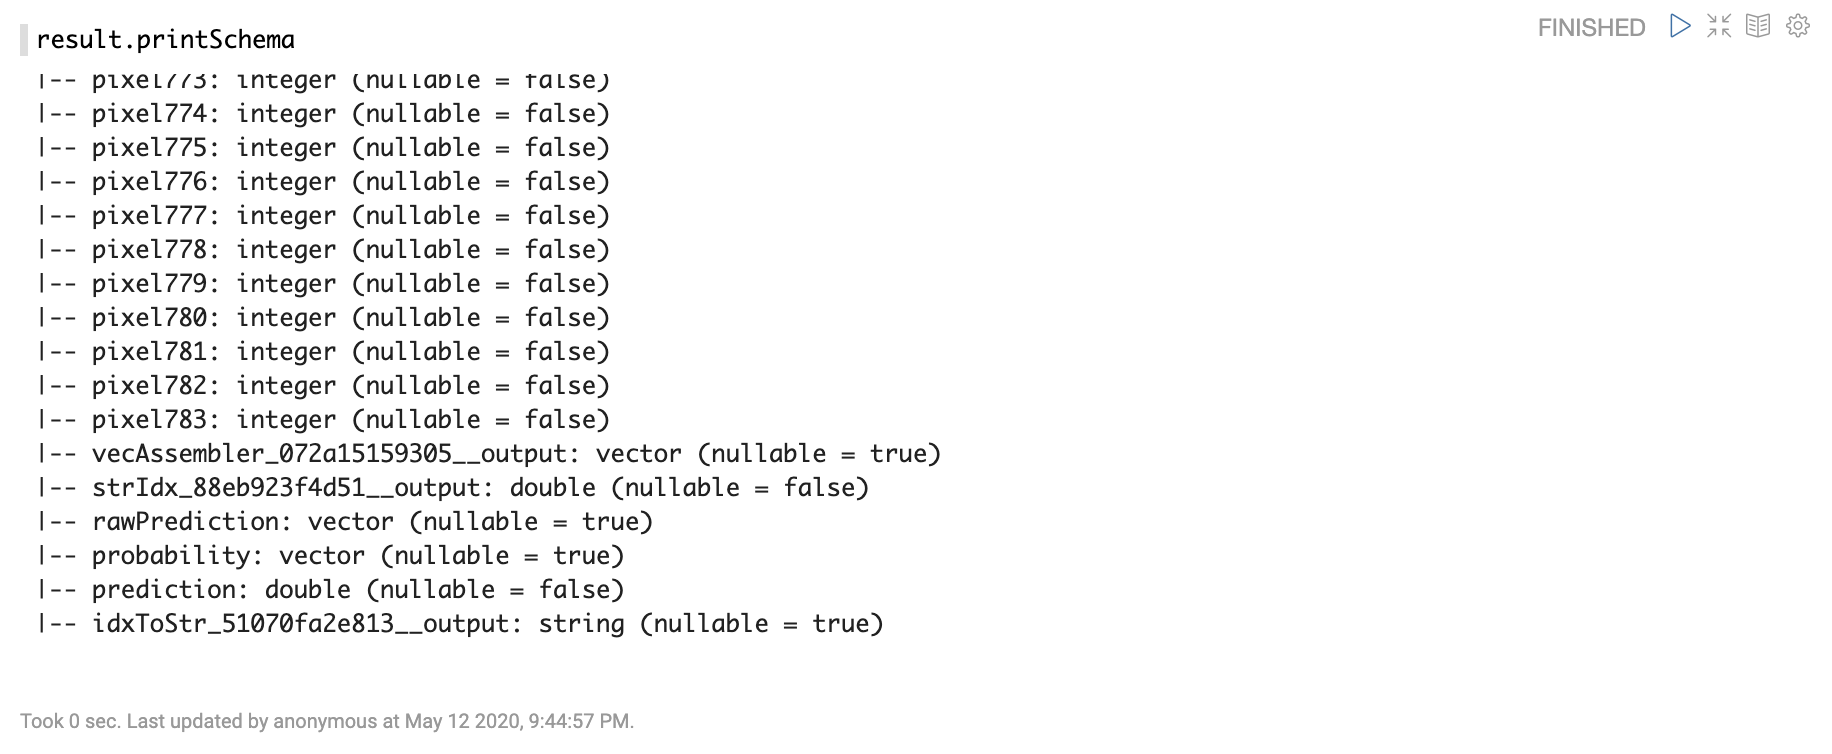

In [29]:
Image('./capture/mnist_24.png')

---
### 결과 확인

 - result output 에서 copy

In [ ]:
result.select(
    "label", 
    "vecAssembler_072a15159305__output",
    "strIdx_88eb923f4d51__output",
    "rawPrediction",
    "probability",
    "prediction",
    "idxToStr_51070fa2e813__output"
).show(1)

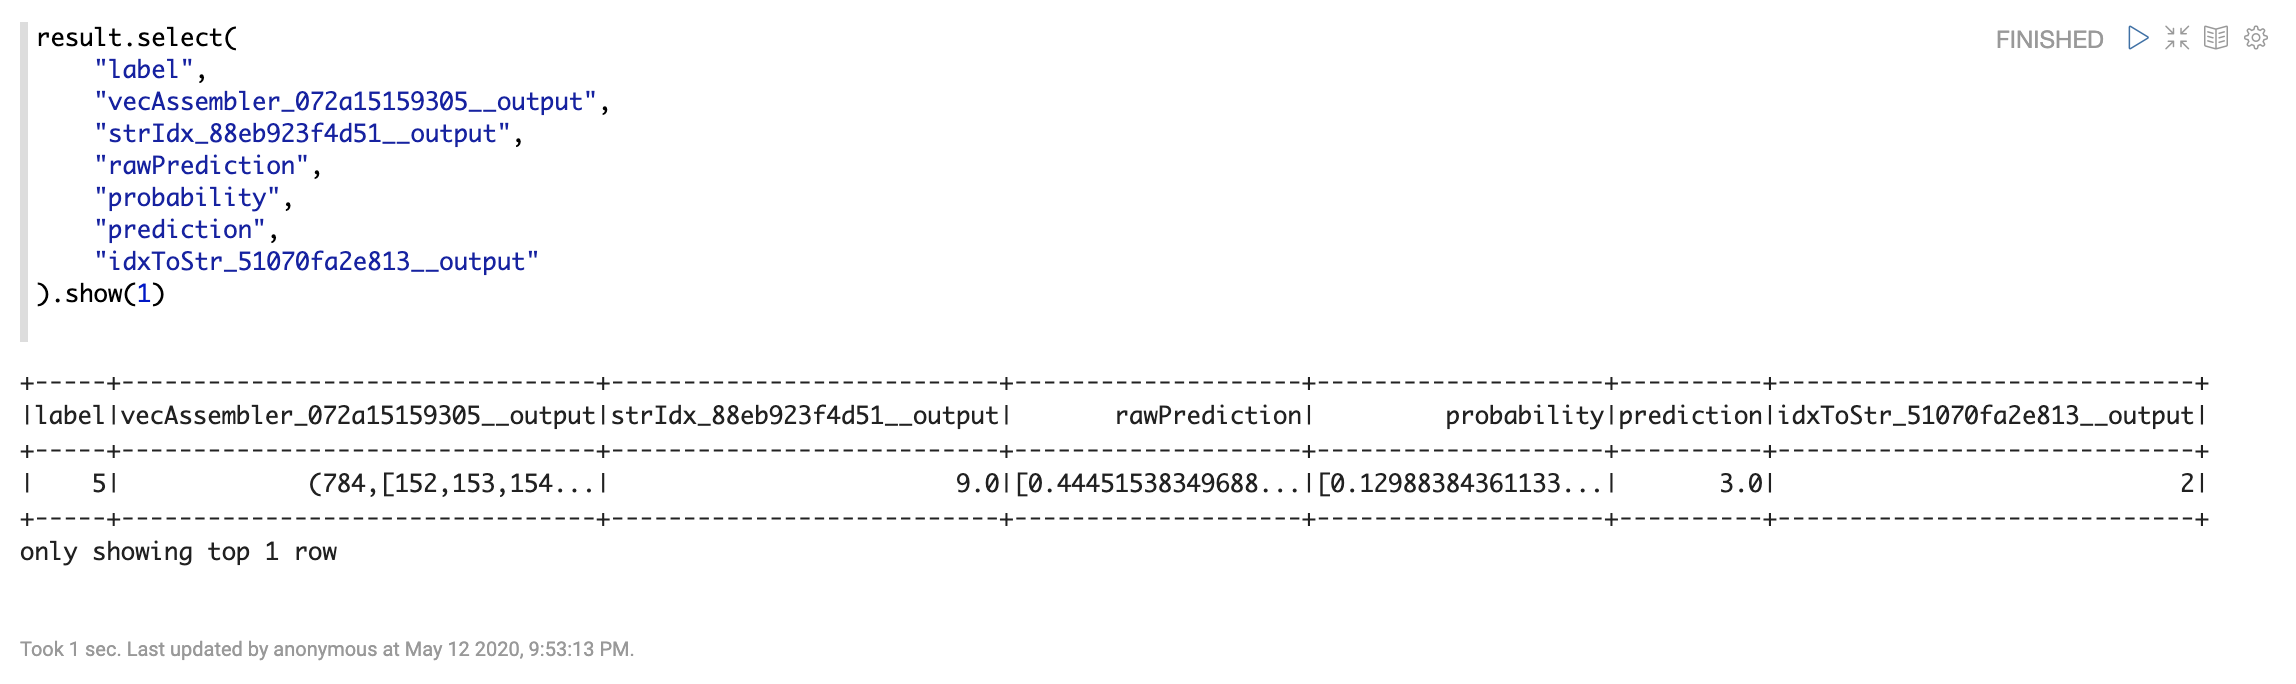

In [30]:
Image('./capture/mnist_25.png')

----
### 평가

 - output column : getOutputCol
 - 예측 column : getPredictionCol

In [ ]:
import org.apache.spark.ml.evaluation.{MulticlassClassificationEvaluator}

val evaluator = { new MulticlassClassificationEvaluator()  
  .setLabelCol(stringIndexer.getOutputCol)
  .setPredictionCol(mlp.getPredictionCol)
  .setMetricName("accuracy")
}

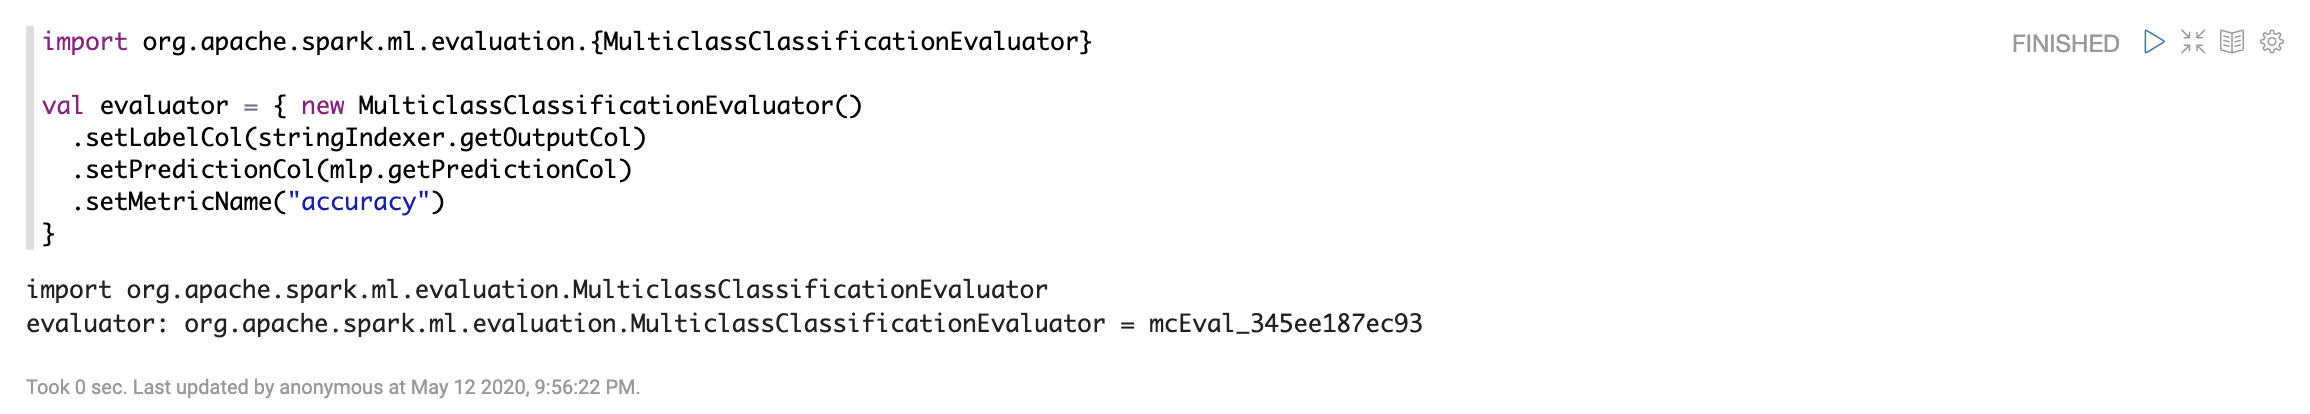

In [31]:
Image('./capture/mnist_26.png')

In [ ]:
val precision = evaluator.evaluate(result)

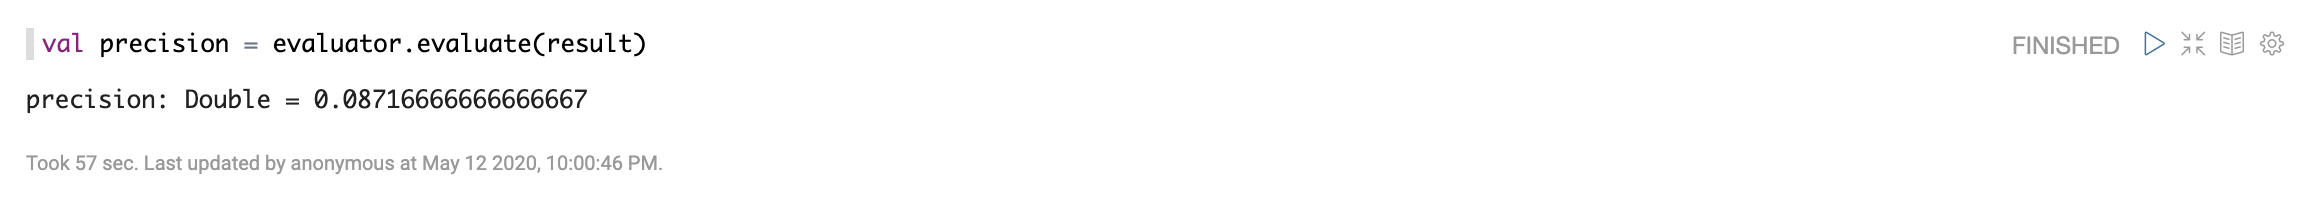

In [32]:
Image('./capture/mnist_27.png')

In [ ]:
val confusionMatrix = {   
  result.select(result(stringIndexer.getInputCol), result(indexToString.getOutputCol))
        .orderBy(stringIndexer.getInputCol)
        .groupBy(stringIndexer.getInputCol)
        .pivot(indexToString.getOutputCol, labels)
        .count
}

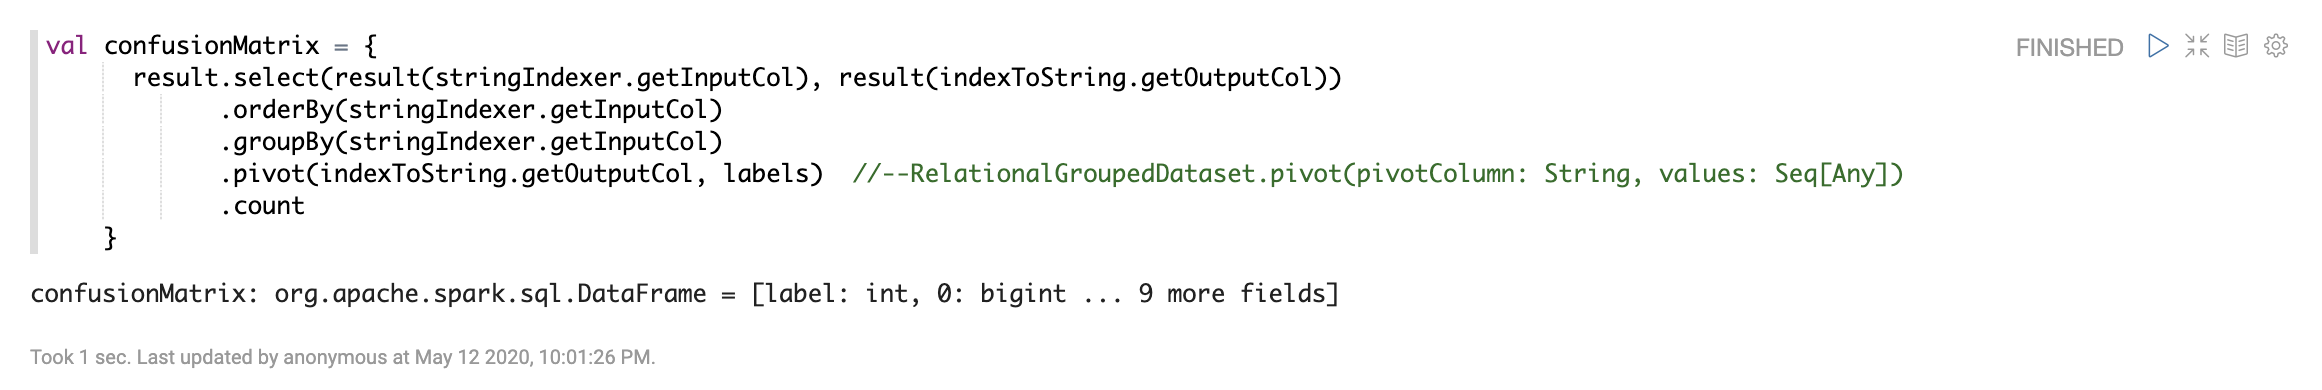

In [33]:
Image('./capture/mnist_28.png')

In [ ]:
println(s"Confusion Matrix (Vertical: Actual, Horizontal: Predicted):")  
    confusionMatrix.show

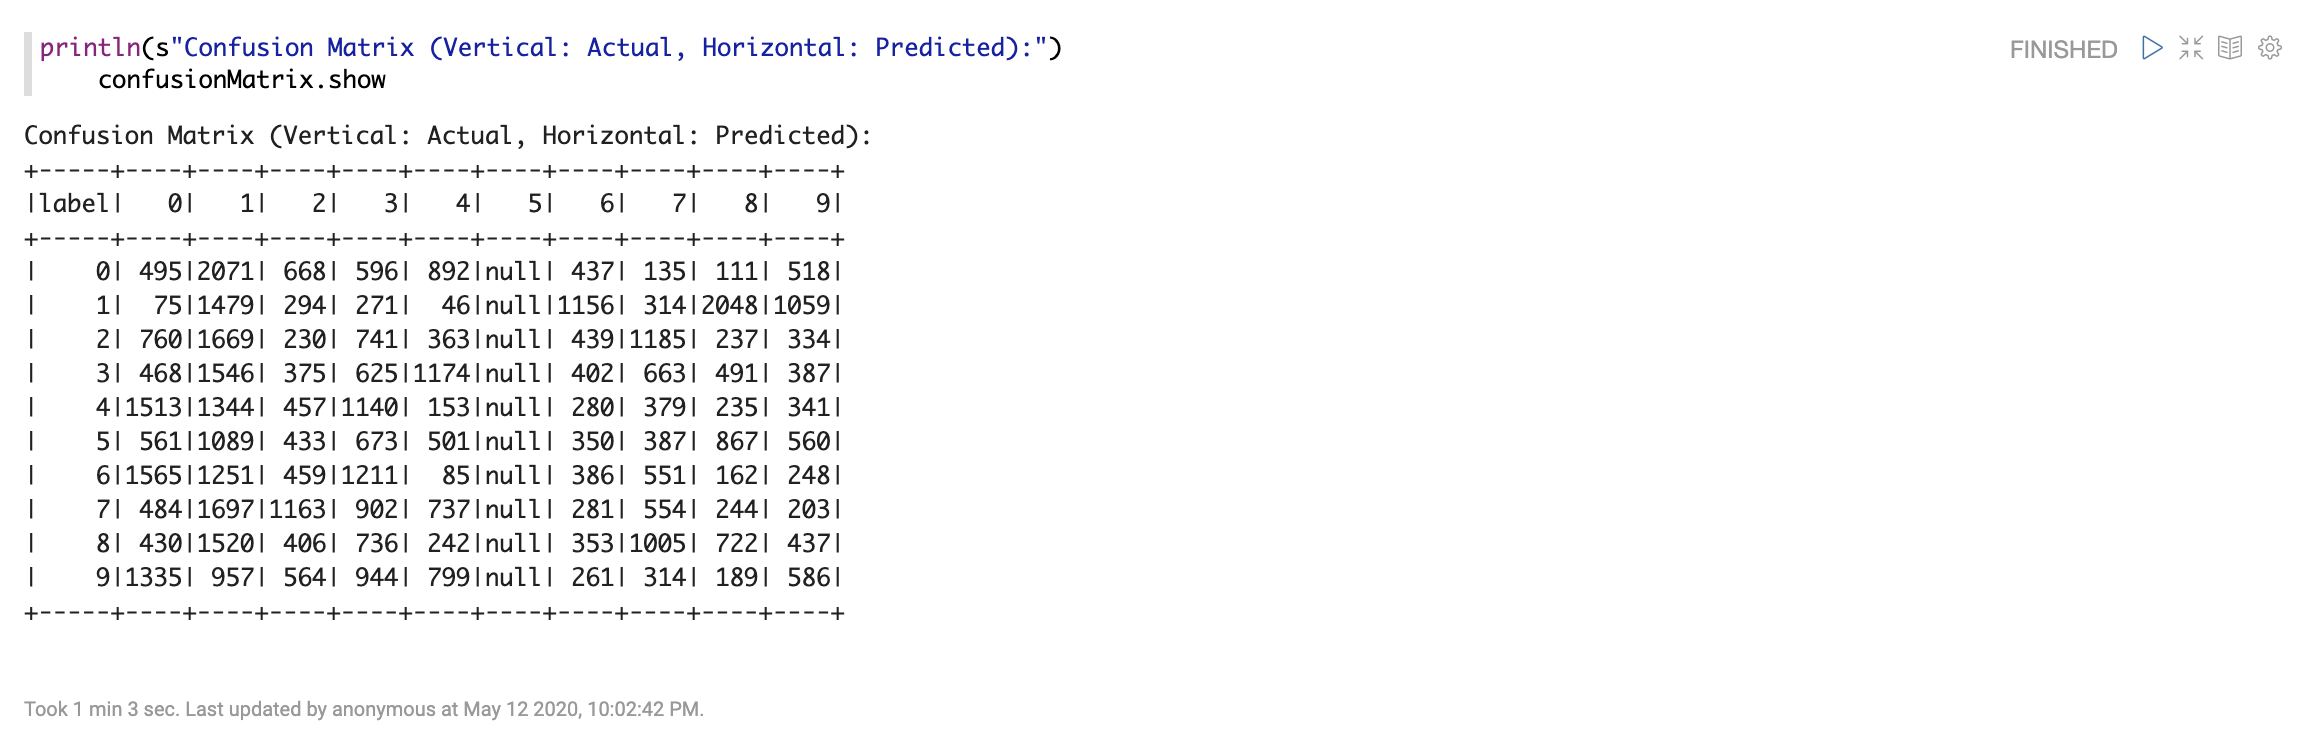

In [34]:
Image('./capture/mnist_29.png')

---
### Save

In [ ]:
pipeline.write.overwrite().save("hdfs://hadoop-master-01:9000/kikang/data/MNIST_mlp" + "/pipeline")
model.write.overwrite().save("hdfs://hadoop-master-01:9000/kikang/data/MNIST_mlp" + "/pipeline-model") 

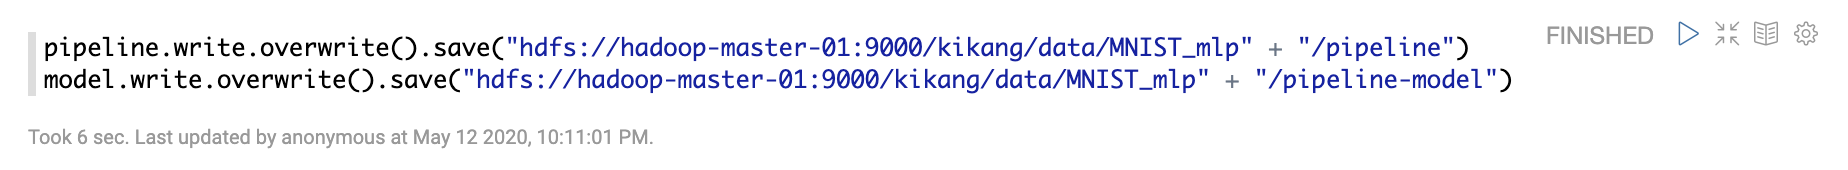

In [35]:
Image('./capture/mnist_30.png')

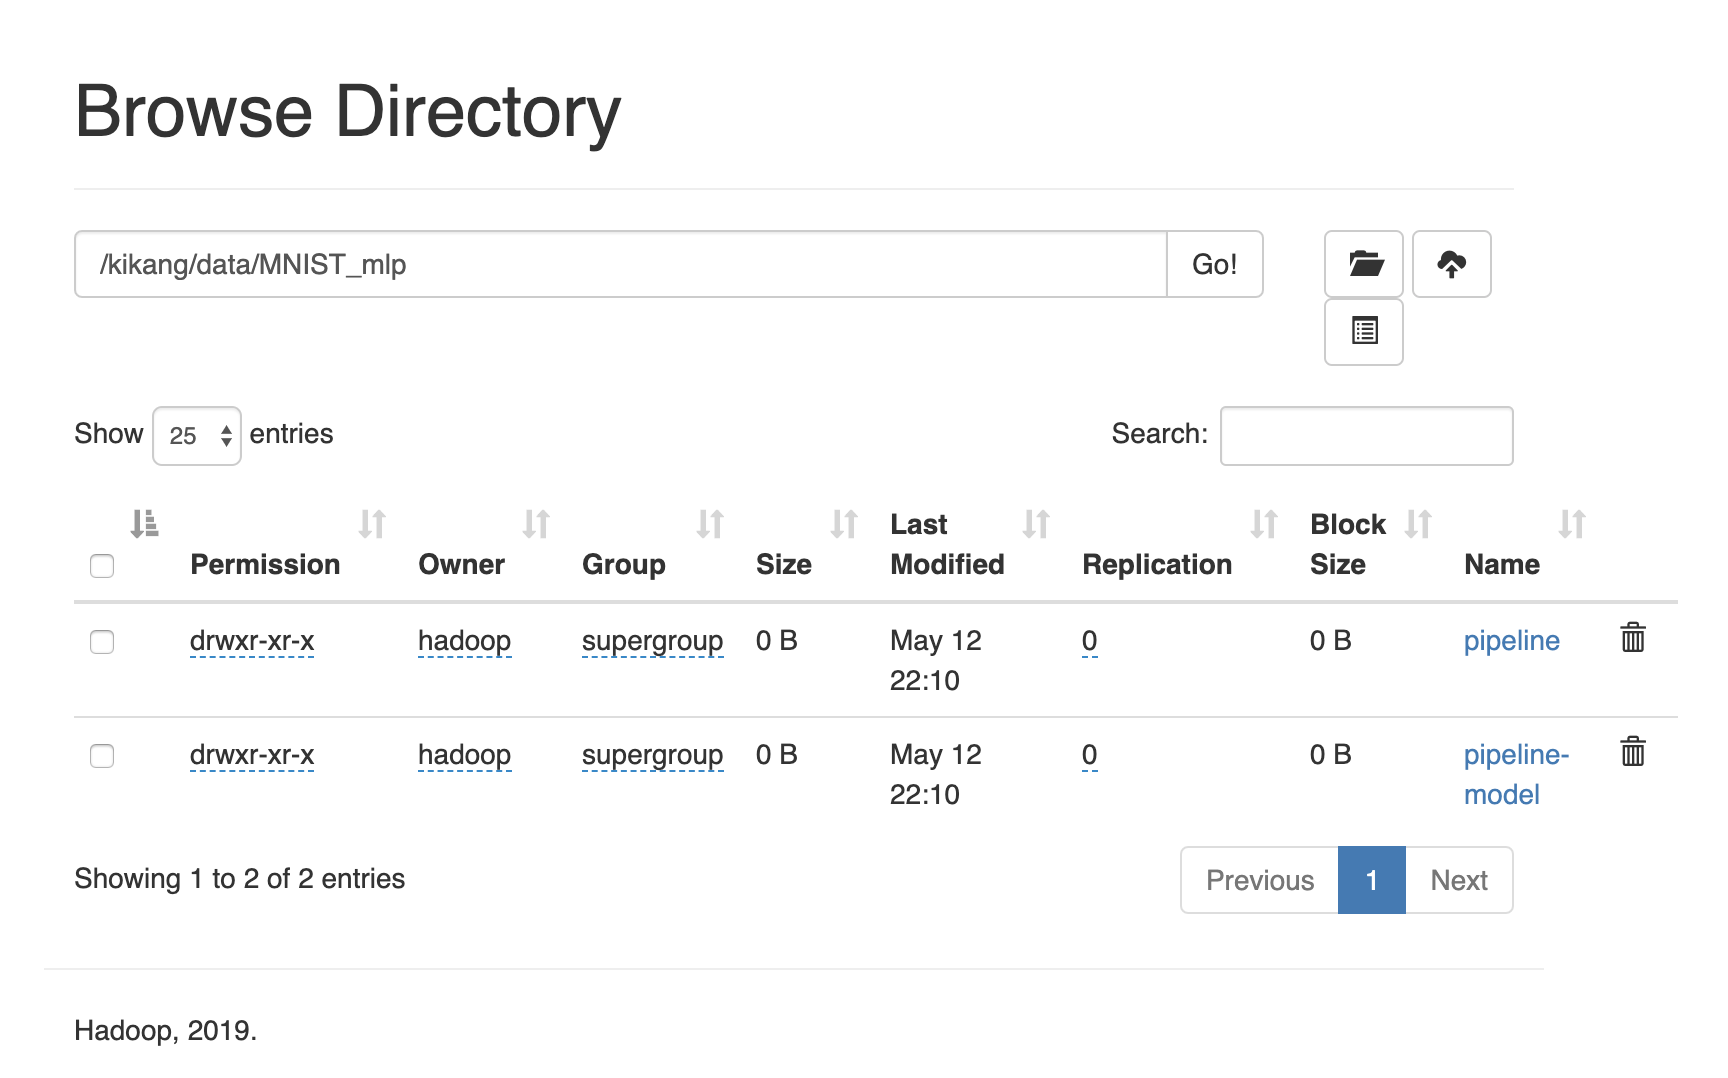

In [36]:
Image('./capture/mnist_31.png')

In [ ]:
train.unpersist()
test.unpersist()

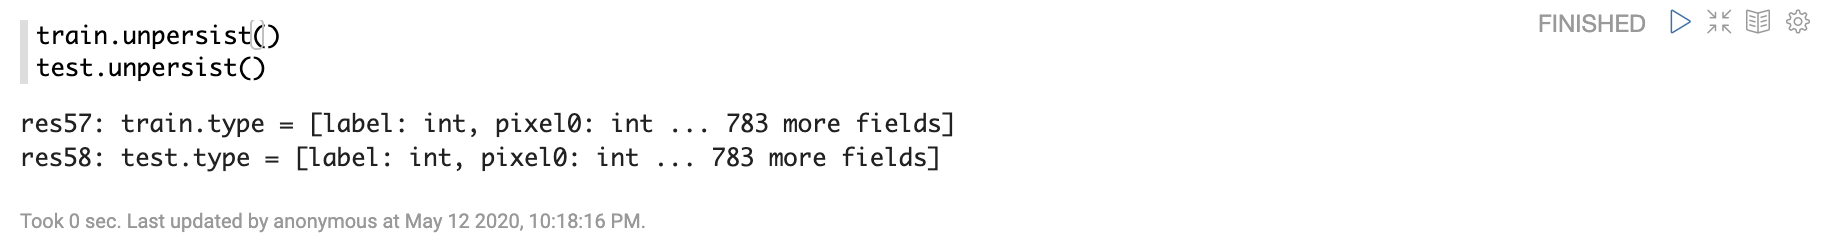

In [37]:
Image('./capture/mnist_32.png')

---
### File upload

 - hadoop-master-01

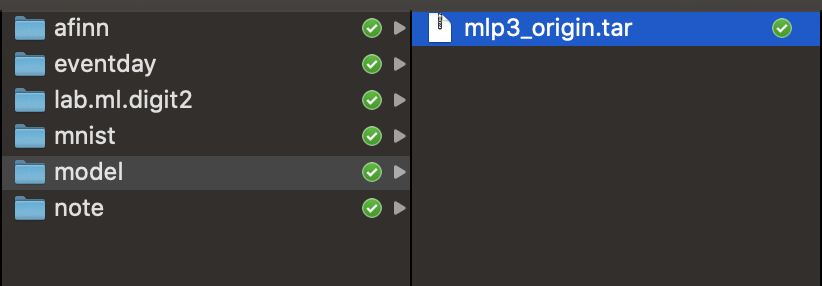

In [38]:
Image('./capture/mnist_33.png')

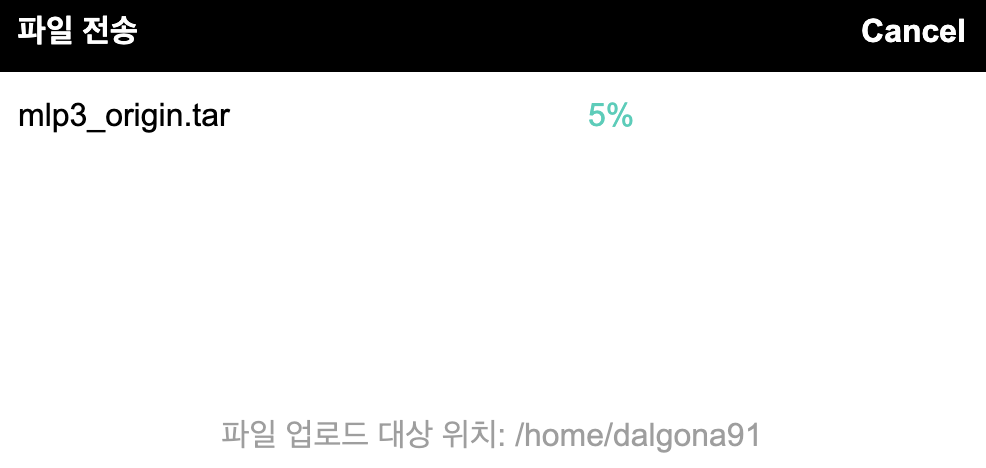

In [39]:
Image('./capture/mnist_34.png')

In [ ]:
$ sudo cp /home/dalgona91/mlp3_origin.tar ./
$ sudo chown hadoop:hadoop ./mlp3_origin.tar 

# tar 압축해제
$ tar xvf mlp3_origin.tar 

# 압축파일 경로
$ pwd
/kikang/kikang/model/mnist/mlp3_origin

# brower create directory
 - MNIST_mlp2

# file upload
$ /kikang/hadoop3/bin/hdfs dfs -put ./* /kikang/data/MNIST_mlp2/